<a href="https://colab.research.google.com/github/ericr6/platform_analysis/blob/main/deal_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task analysis of iExec MArketplace
This notebook create dataframe using the graph,then from the dataframe you can easily create dashboard or explore data.

Section 0 : import and functions needed

Section 1 : retrieve latest data, latest N days with parameter N

Section 2 : Platform Availability indicator

Section 3 : Visualize recent activity

Section 4 : Save historical data in google drive [DO NOT USE]

Section 5 : Load full historical data from google drive

Section 6 : Visualisation from historical data

## Section 0 : import and functions needed


In [ ]:
# @title import stuffs
import requests
import json
import csv
from datetime import datetime, timedelta
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# @title Common Functions
# Function to convert Hexa String to Text
def hex_to_string(value):
    if not value:
        return value

    bytes_from_hex = bytes.fromhex(value[2:])
    return bytes_from_hex.decode('utf-8')

def filter_by_time_interval(data_list, date_begin, date_end):
    # Convert date_begin and date_end strings to datetime objects
    #date_begin = datetime.strptime(date_begin, '%Y-%m-%d %H:%M:%S')
    #date_end = datetime.strptime(date_end, '%Y-%m-%d %H:%M:%S')

    # Filter data_list based on timestamp falling within the specified time interval
    filtered_data = [row for row in data_list if date_begin <= datetime.utcfromtimestamp(int(row[5])) <= date_end]
    return filtered_data



def get_api_data_iexec_interval(url_query, query, global_skip, date_begin=None, date_end=None):
    total_data = []
    are_data = True
    detected = False
    skip = 0
    while are_data and skip < 200000 or not detected:

        # Construct the query with skip parameter and optional date filters
        query_iter = query.replace("skip_param", str(global_skip + skip))

        options = {
            'headers': {'Content-Type': 'application/json'},
            'data': '{"query": "' + query_iter + '"}',
        }

        response = requests.post(url_query, **options)

        # Check if the response contains valid JSON data
        response.raise_for_status()
        data = response.json()

        array_data = data.get('data', {}).get('taskInitializes', [])

        grouped = [
            [
                e['task']['id'],
                e['task']['deal']['app']['name'],
                hex_to_string(e['task']['deal']['app']['multiaddr']),
                e['task']['deal']['tag'],
                e['task']['status'],
                #pd.to_datetime(int(e['task']['timestamp']) * 1000000).strftime('%Y-%m-%d %H:%M:%S'),
                e['task']['timestamp'],
                e['task']['deal']['workerpool']['id'],
                e['task']['deal']['requester']['id']
            ]
            for e in array_data
        ]

        grouped = filter_by_time_interval(grouped, date_begin, date_end)

        total_data.extend(grouped)
        skip += 500
        _are_data = len(grouped) > 0
        if _are_data > 0 and are_data:
 #           print ("detected is true")
            detected = True
        are_data = len(grouped) > 0
        print("i= " + str(global_skip + skip) + " are_data: " + str(are_data) + "_are_data: " + str(_are_data) + " grouped size " +  str(len(grouped)) + " array_data size: " + str(len(array_data))  )
    return total_data



# Actualize data
url_query_bellecour = 'https://thegraph.bellecour.iex.ec/subgraphs/name/bellecour/poco-v5'
query = '{\
                taskInitializes(first:500, skip: skip_param, orderBy: timestamp, orderDirection: desc){\
                  task{\
                    id,\
                    deal{\
                      requester {\
                        id\
                      }\
                      app{\
                        name\
                        multiaddr\
                      }\
                      dataset{\
                        name\
                      }\
                      workerpool{\
                        id\
                         }\
                      tag\
                    }\
                    status,\
                    timestamp\
                  }\
                }\
              }'




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Knwown iExec wallet

iexec_wallet=[
    "0x8d6f890ea5d10134cd6b9777457eb75e76312304",
    "0x2d65d4f5916a78cbe6e8088dbf29865a0f055f4d",
    "0x4d67487894140752d1a0dc81e77a578796e47255",
    "0x1d6ce6c05043c28672218b103acb1e017babb68e",
    "0x6d6b5e88714263bbc6b4fa21a7328a7b947a302c",
    "0x7d695b9a362e15090ce26711808bc89c18efa70f",
    "0x5d62abd17f0a7f1004c981d5cff24c5a88d849f5",
    "0x3d60589cb7a862e3001b8e7eff1ec248d1f16a18",
    "0xabcd1339ec7e762e639f4887e2bfe5ee8023e23e",
    "0x000a9c787a972f70f0903890e266f41c795c4dca"
    ]


## Section 1 : retrieve latest data


In [ ]:
# @title Get latest data ; Select N Days

#Method 2: with Date
date_end = datetime.now()
date_begin = date_end - timedelta(days=30)

print ("Period to retrieve:", date_begin, date_end)

api_data = get_api_data_iexec_interval(url_query_bellecour, query, 0, date_begin, date_end)
df_tasks_30d = pd.DataFrame(api_data, columns=["TASK_ID","APP NAME", "APP MULTIADDR", "TAG", "STATUS", "DATE", "WORKERPOOL ID", "REQUESTER ID"])
df_tasks_30d["DATE"] = [datetime.utcfromtimestamp(int(x)) for x in df_tasks_30d["DATE"]]

print("Period observed", df_tasks_30d["DATE"].min(), df_tasks_30d["DATE"].max())
print("dataset length: " + str(df_tasks_30d.shape[0]))

#print(filename)


Period to retrieve: 2024-02-17 07:42:18.105510 2024-03-18 07:42:18.105510
i= 500 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 1000 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 1500 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 2000 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 2500 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 3000 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 3500 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 4000 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 4500 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 5000 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 5500 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 6000 are_data: True_are_data: True grouped size 500 array_data size: 500
i= 6500 are_dat

Check dataset structure and data header, you can share to chatgpt this data structure, and ask him to plot anything you want, he will propose the code, then create a computing box and insert the code directly here to obtain what you ask

In [ ]:
df_tasks_30d.dtypes


TASK_ID                  object
APP NAME                 object
APP MULTIADDR            object
TAG                      object
STATUS                   object
DATE             datetime64[ns]
WORKERPOOL ID            object
REQUESTER ID             object
dtype: object

In [ ]:
df_tasks_30d

,TASK_ID,APP NAME,APP MULTIADDR,TAG,STATUS,DATE,WORKERPOOL ID,REQUESTER ID
0,0xe345b2fc524718e3e940d659dafec774a87620b9f3e5...,tee-python-hello-world:8.0.3-gramine,docker.io/iexechub/tee-python-hello-world:8.0....,0x00000000000000000000000000000000000000000000...,ACTIVE,2024-03-18 07:42:05,0xca76ab007f8a3fb64076851bb01acc99fc26d27b,0x5d62abd17f0a7f1004c981d5cff24c5a88d849f5
1,0xc53a373bd6b8555657e6237196c81106c713e1c4fb88...,python-hello-world:8.0.0-sconify-5.7.5-v14-pro...,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-03-18 07:36:15,0x0e7bc972c99187c191a17f3cae4a2711a4188c3f,0x6d6b5e88714263bbc6b4fa21a7328a7b947a302c
2,0xd62f49350db4a77ce3203fb2bf1e238d015410b4269f...,python-hello-world:8.0.0-sconify-5.7.5-v14-debug,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-03-18 07:34:30,0xdb214a4a444d176e22030be1ed89da1b029320f2,0x7d695b9a362e15090ce26711808bc89c18efa70f
3,0x47b40d3b40e84a72fda63c8a1fddaa1ac0d5d8f603d0...,python-hello-world:8.0.0-sconify-5.7.6-v15-pro...,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-03-18 07:26:30,0xca76ab007f8a3fb64076851bb01acc99fc26d27b,0x3d60589cb7a862e3001b8e7eff1ec248d1f16a18
4,0xeb15f32de5346781efd4ba7efd773a1394b18ed6637e...,python-hello-world:8.0.0-sconify-5.7.6-v15-debug,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-03-18 07:24:35,0xcfc79bf7ce221c504e281b42b4f50b1a0e692cb6,0x4d67487894140752d1a0dc81e77a578796e47255
...,...,...,...,...,...,...,...,...
11891,0x92f342d9cf93e523b65085e733ed4e483d71d258bd23...,python-hello-world:8.0.0-sconify-5.7.5-v14-pro...,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-02-17 07:57:05,0x0e7bc972c99187c191a17f3cae4a2711a4188c3f,0x6d6b5e88714263bbc6b4fa21a7328a7b947a302c
11892,0x23d8db34be141051fc23cfd0e8902effda5f2594c1c6...,python-hello-world:8.0.0-sconify-5.7.5-v14-debug,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-02-17 07:55:15,0xdb214a4a444d176e22030be1ed89da1b029320f2,0x7d695b9a362e15090ce26711808bc89c18efa70f
11893,0x4302a2bbbffa1a1bc419e8f945c4020af25ce9d4b7ce...,tee-python-hello-world:8.0.3-gramine,docker.io/iexechub/tee-python-hello-world:8.0....,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-02-17 07:54:05,0x0e7bc972c99187c191a17f3cae4a2711a4188c3f,0x8d6f890ea5d10134cd6b9777457eb75e76312304
11894,0x9b1e9d671d4da11f9c81de70774be7ae500cbdecce52...,python-hello-world:8.0.0-sconify-5.7.5-v14-debug,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,ACTIVE,2024-02-17 07:44:40,0xcfc79bf7ce221c504e281b42b4f50b1a0e692cb6,0x4d67487894140752d1a0dc81e77a578796e47255


## Section 2 Platform Availibility

```
# This is formatted as code
```



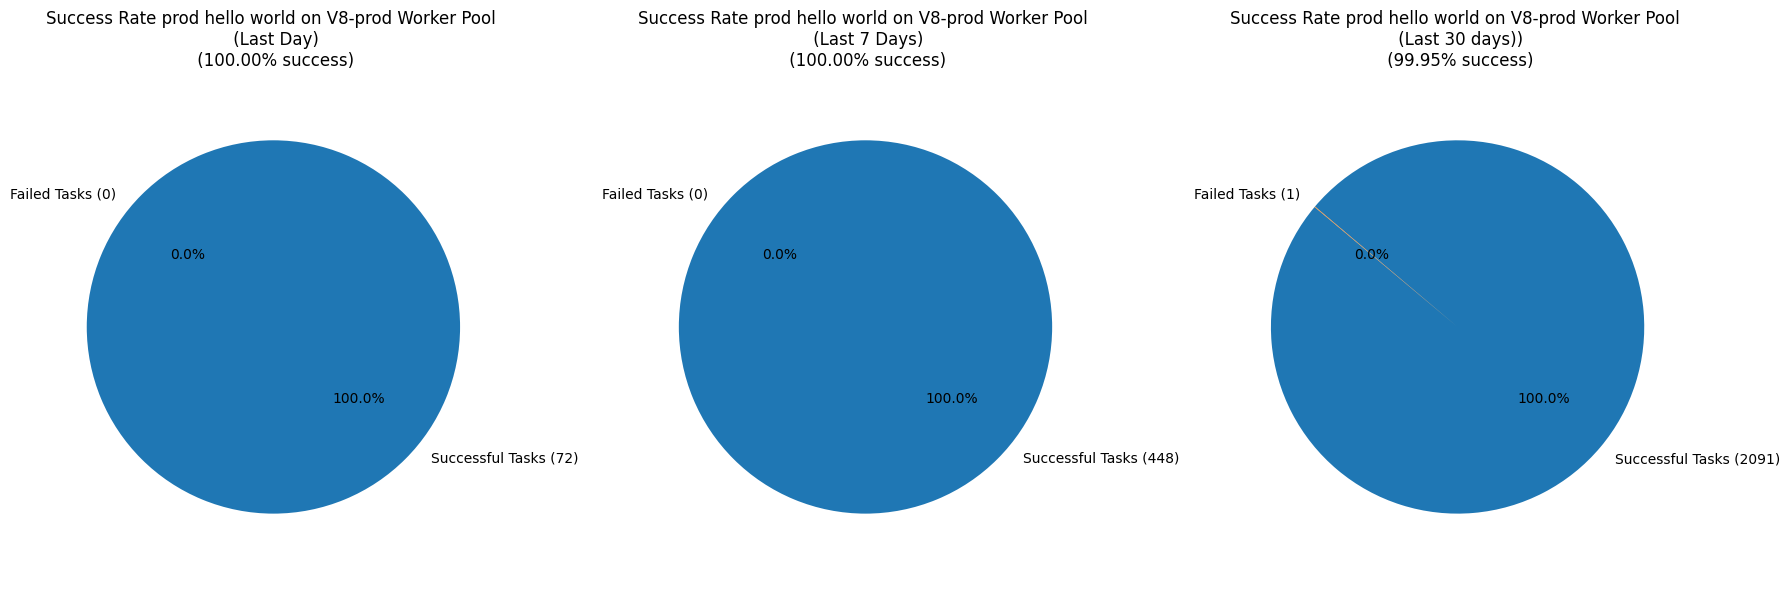

In [ ]:
# @title Platform Availibility

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# Function to calculate the percentage of successful tasks
def calculate_success_percentage(total_tasks, successful_tasks):
    if total_tasks == 0:
        return 0
    return (successful_tasks / total_tasks) * 100

# Function to plot a pie chart with percentage and value
def plot_pie_chart(ax, successful_tasks, total_tasks, title):
    success_percentage = calculate_success_percentage(total_tasks, successful_tasks)
    failed_tasks = total_tasks - successful_tasks

    ax.pie([successful_tasks, failed_tasks], labels=[f'Successful Tasks ({successful_tasks})', f'Failed Tasks ({failed_tasks})'], autopct='%1.1f%%', startangle=140,colors=['lightgreen', 'lightcoral'])
    ax.set_title(title + f' ({success_percentage:.2f}% success)', fontsize=12, fontweight='bold')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    ax.legend(loc='upper right', fontsize=10)

# Define the date interval
date_begin = df_tasks_30d['DATE'].min().strftime("%Y-%m-%d")
date_end = df_tasks_30d['DATE'].max().strftime("%Y-%m-%d")

# Assuming 'df_tasks_30d' is your DataFrame with task data

# Calculate the date range for each time interval
end_date = datetime.now()
start_date_last_day = end_date - timedelta(days=1)
start_date_last_7days = end_date - timedelta(days=7)

# Filter the DataFrame for each time interval
df_last_day = df_tasks_30d[(df_tasks_30d['DATE'] >= start_date_last_day) & (df_tasks_30d['DATE'] <= end_date)]
df_last_7days = df_tasks_30d[(df_tasks_30d['DATE'] >= start_date_last_7days) & (df_tasks_30d['DATE'] <= end_date)]
df_alltime = df_tasks_30d

# Replace 'specific_workerpool_id' with the actual ID of the worker pool you're interested in
specific_workerpool_id = '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f'
specific_app= 'docker.io/iexechub/python-hello-world:8.0.0-sconify-5.7.5-v14-production'

# Filter the DataFrame further for the specific worker pool
df_last_day_specific1 = df_last_day[df_last_day['WORKERPOOL ID'] == specific_workerpool_id]
df_last_7days_specific1 = df_last_7days[df_last_7days['WORKERPOOL ID'] == specific_workerpool_id]
df_alltime_specific1 = df_alltime[df_alltime['WORKERPOOL ID'] == specific_workerpool_id]
# Filter for specific application if needed
df_last_day_specific= df_last_day_specific1[df_last_day_specific1['APP MULTIADDR'] == specific_app]
df_last_7days_specific = df_last_7days_specific1[df_last_7days_specific1['APP MULTIADDR'] == specific_app]
df_alltime_specific = df_alltime_specific1[df_alltime_specific1['APP MULTIADDR'] == specific_app]

# Calculate the total number of tasks and successful tasks for each time interval
total_tasks_last_day = len(df_last_day_specific)
successful_tasks_last_day = len(df_last_day_specific[df_last_day_specific['STATUS'] == 'COMPLETED'])
total_tasks_last_7days = len(df_last_7days_specific)
successful_tasks_last_7days = len(df_last_7days_specific[df_last_7days_specific['STATUS'] == 'COMPLETED'])
total_tasks_alltime = len(df_alltime_specific)
successful_tasks_alltime = len(df_alltime_specific[df_alltime_specific['STATUS'] == 'COMPLETED'])

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
text1=(f'({date_begin} to {date_end})')
# Plot pie charts for each time interval
plot_pie_chart(axs[0], successful_tasks_last_day, total_tasks_last_day, 'Success Rate prod hello world on V8-prod Worker Pool \n (Last Day)\n')
plot_pie_chart(axs[1], successful_tasks_last_7days, total_tasks_last_7days, 'Success Rate prod hello world on V8-prod Worker Pool \n (Last 7 Days)\n')
plot_pie_chart(axs[2], successful_tasks_alltime, total_tasks_alltime, 'Success Rate prod hello world on V8-prod Worker Pool \n (Last 30 days))\n')
# Adjust layout and show plot
plt.tight_layout()
plt.show()


<ipython-input-9-caa5f5858241>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alltime_specific['Minutes'] = df_alltime_specific['DATE'].dt.hour * 60 + df_alltime_specific['DATE'].dt.minute
<ipython-input-9-caa5f5858241>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alltime_specific['Hour_Minutes'] = df_alltime_specific['Minutes'] % (24 * 60)


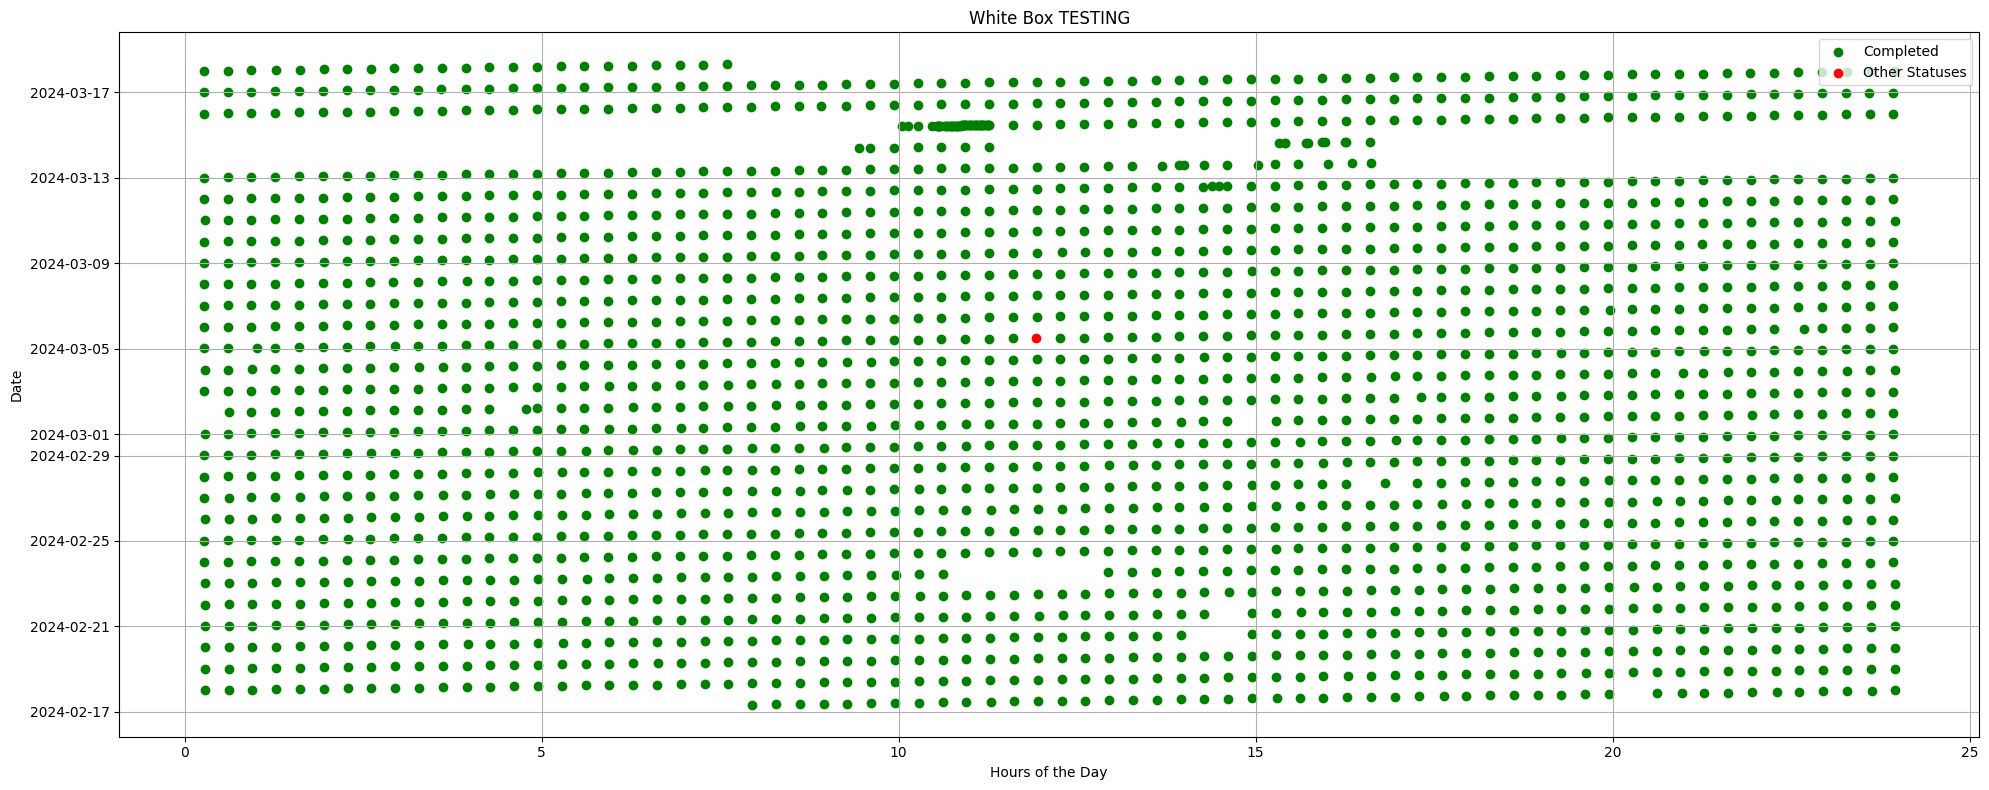

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_alltime_specific contains your DataFrame with the provided structure

plt.figure(figsize=(20, 8))

# Replace 'specific_workerpool_id' with the actual ID of the worker pool you're interested in
specific_workerpool_id = '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f'
specific_app = 'docker.io/iexechub/python-hello-world:8.0.0-sconify-5.7.5-v14-production'

# Filter the DataFrame further for the specific worker pool
df_alltime_specific1 = df_tasks_30d[df_tasks_30d['WORKERPOOL ID'] == specific_workerpool_id].copy()
# Filter for specific application if needed
df_alltime_specific = df_alltime_specific1[df_alltime_specific1['APP MULTIADDR'] == specific_app].copy()

# Calculate the total minutes since midnight
df_alltime_specific['Minutes'] = df_alltime_specific['DATE'].dt.hour * 60 + df_alltime_specific['DATE'].dt.minute

# Apply modulo operation to get only hour and minutes
df_alltime_specific['Hour_Minutes'] = df_alltime_specific['Minutes'] % (24 * 60)

# Plot successful points
plt.scatter(df_alltime_specific[df_alltime_specific['STATUS'] == 'COMPLETED']['Hour_Minutes'] / 60,
            df_alltime_specific[df_alltime_specific['STATUS'] == 'COMPLETED']['DATE'],
            color='green', label='Completed')

# Plot unsuccessful points
plt.scatter(df_alltime_specific[df_alltime_specific['STATUS'] != 'COMPLETED']['Hour_Minutes'] / 60,
            df_alltime_specific[df_alltime_specific['STATUS'] != 'COMPLETED']['DATE'],
            color='red', label='Other Statuses')

plt.title('Black Box Test')
plt.xlabel('Hours of the Day')
plt.ylabel('Day')

# Create a single legend for both success and failure
plt.legend()

plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
import pandas as pd

# Assuming df_alltime_specific contains your DataFrame with the provided structure

# Sort the DataFrame by DATE to ensure sequential observations
df_alltime_specific_sorted = df_alltime_specific.sort_values(by='DATE')
test=df_alltime_specific_sorted
# Initialize variables to track "up" time intervals and downtime intervals
up_intervals = []
down_intervals = []

# Initialize variables to track the start time and count of successful tasks within the interval
start_time = None
success_count = 0
test.index = pd.RangeIndex(1, len(test.index) + 1)
up=pd.Timedelta(0)
down=pd.Timedelta(0)
down_intervals = []

# Iterate over the sorted DataFrame
for index, row in test.iterrows():
    if index < len(test) - 1:
        next_row = test.loc[index + 1]

        # Check if both the current and next observations are COMPLETED
        if (row["STATUS"] == "COMPLETED") and (next_row["STATUS"] == "COMPLETED"):
            # Check if the time between the current and next observations is less than or equal to 22 minutes
            if (next_row['DATE'] - row["DATE"]) <= pd.Timedelta(minutes=22):
                up += next_row['DATE'] - row["DATE"]
            else:
                # If the time between observations is more than 22 minutes, it's considered as down
                down += next_row['DATE'] - row["DATE"]
                down_intervals.append((row['DATE'], next_row["DATE"]))
        else:
            # If either the current or next observation is not COMPLETED, it's considered as down
            down += next_row['DATE'] - row["DATE"]
            down_intervals.append((row['DATE'], next_row["DATE"]))

# Print down intervals
print("Down Intervals:")
for start, end in down_intervals:
    start_time = start.strftime('%Y-%m-%d %H:%M:%S')
    end_time = end.strftime('%Y-%m-%d %H:%M:%S')
    print(f" [ {start_time}  -> {end_time} ] Duration: {end - start} ")

# Merge consecutive intervals
compressed_intervals = []
start, end = down_intervals[0]
for interval in down_intervals[1:]:
    if interval[0] - end <= pd.Timedelta(minutes=1):
        end = interval[1]
    else:
        compressed_intervals.append((start, end))
        start, end = interval
compressed_intervals.append((start, end))

print("Down compressed:")

# Print compressed intervals
print("\nDown compressed Intervals:")
for start, end in compressed_intervals:
    start_time = start.strftime('%Y-%m-%d %H:%M:%S')
    end_time = end.strftime('%Y-%m-%d %H:%M:%S')
    print(f" [ {start_time}  -> {end_time} ] Duration: {end - start} ")

# Calculate total time, availability percentage
total_time = df_alltime_specific_sorted["DATE"].max() - df_alltime_specific_sorted["DATE"].min()
up_percentage = (up / (up + down)) * 100

# Print summary
print("\nSummary:")
print(f"Total Time: {total_time}")
print(f"Up period: {up}")
print(f"Down period: {down}")
print(f"Availability Percentage: {up_percentage}%")


Downtime Intervals:
 [ 2024-02-17 19:57:25  -> 2024-02-17 20:37:40 ] Duration: 0 days 00:40:15 
 [ 2024-02-20 13:57:50  -> 2024-02-20 14:57:25 ] Duration: 0 days 00:59:35 
 [ 2024-02-21 14:17:20  -> 2024-02-21 14:57:45 ] Duration: 0 days 00:40:25 
 [ 2024-02-23 10:37:50  -> 2024-02-23 12:56:20 ] Duration: 0 days 02:18:30 
 [ 2024-02-27 16:16:40  -> 2024-02-27 16:49:45 ] Duration: 0 days 00:33:05 
 [ 2024-02-27 16:49:45  -> 2024-02-27 17:16:10 ] Duration: 0 days 00:26:25 
 [ 2024-02-29 16:36:30  -> 2024-02-29 16:58:50 ] Duration: 0 days 00:22:20 
 [ 2024-03-01 14:36:30  -> 2024-03-01 15:17:30 ] Duration: 0 days 00:41:00 
 [ 2024-03-01 23:56:35  -> 2024-03-02 00:37:05 ] Duration: 0 days 00:40:30 
 [ 2024-03-02 04:16:20  -> 2024-03-02 04:47:30 ] Duration: 0 days 00:31:10 
 [ 2024-03-02 16:56:30  -> 2024-03-02 17:19:00 ] Duration: 0 days 00:22:30 
 [ 2024-03-03 20:36:45  -> 2024-03-03 20:59:10 ] Duration: 0 days 00:22:25 
 [ 2024-03-05 00:36:20  -> 2024-03-05 01:01:25 ] Duration: 0 days 00

## Section 3 : Visualize recent activity

<ipython-input-42-cd886085f281>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_staginghist['DATE'] = pd.to_datetime(df_staginghist['DATE'])
<ipython-input-42-cd886085f281>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_staginghist['Day'] = df_staginghist['DATE'].dt.to_period('d')


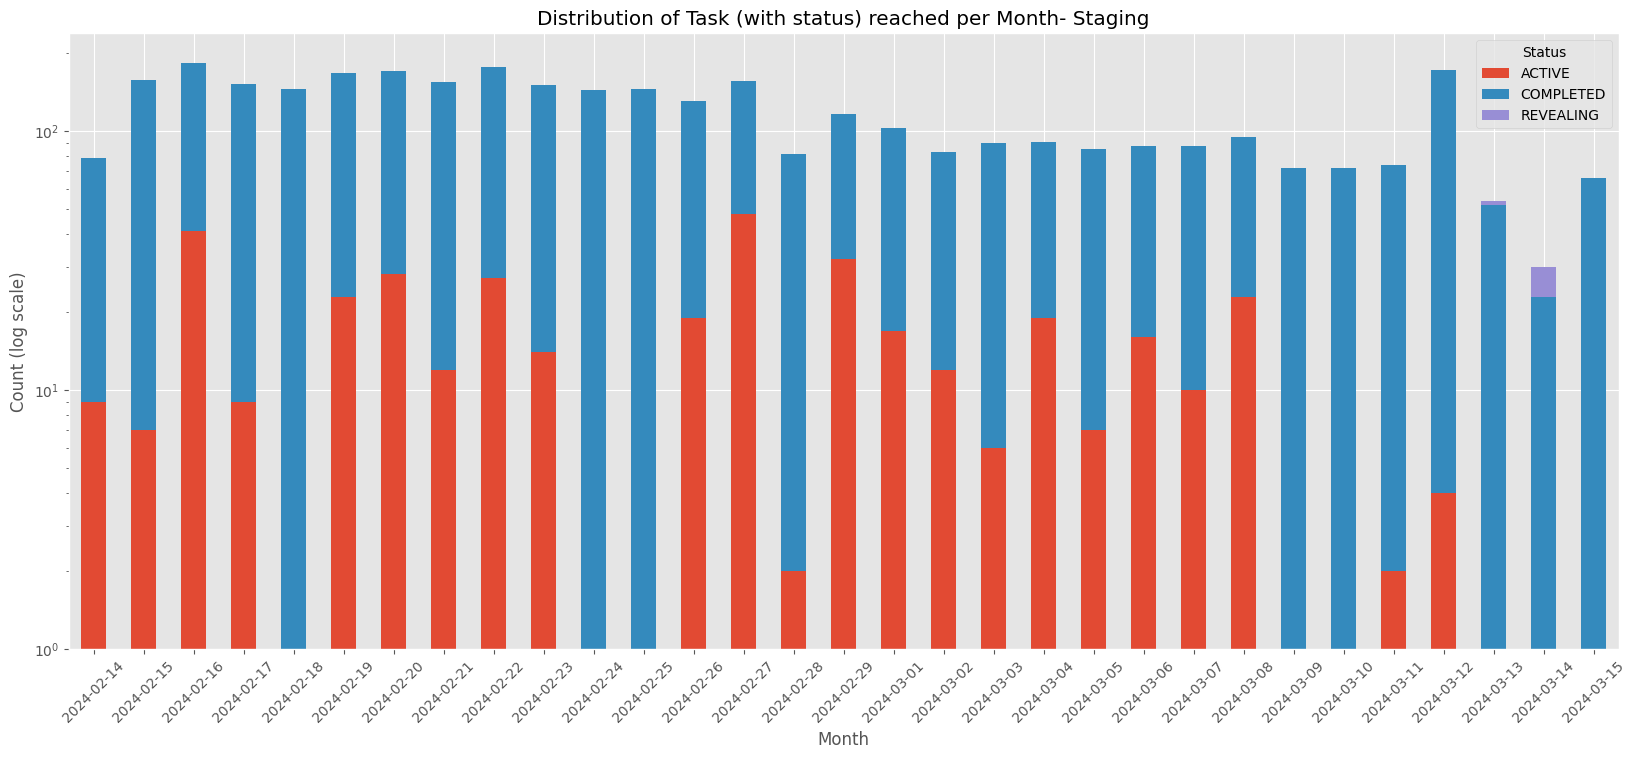

<Figure size 1920x1440 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
# Convert DATE column to datetime if it's not already
# Replace 'specific_workerpool_id' with the actual ID of the worker pool you're interested in
specific_workerpool_id = '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f'  #prod
#specific_workerpool_id= '0x64cbf560b5b61c692d90d4507f2834408a03aaf6'

# Filter the DataFrame further for the specific worker pool
df_taskday = df_tasks_30d[df_tasks_30d['WORKERPOOL ID'] == specific_workerpool_id].copy()

df_taskday['DATE'] = pd.to_datetime(df_taskday['DATE'])
# Define the date interval
start_date = df_taskday['DATE'].min().strftime("%Y-%m-%d")
end_date = df_taskday['DATE'].max().strftime("%Y-%m-%d")

# Extract month from the DATE column
df_taskday['Day'] = df_taskday['DATE'].dt.to_period('d')

# Group by Month and STATUS, count occurrences
status_counts = df_taskday.groupby(['Day', 'STATUS']).size().unstack(fill_value=0)

# Plot
status_counts.plot(kind='bar', stacked=True, figsize=(20, 8))

plt.title('Tasks per day \n (Workerpool: V8-prod {}) \n Start Date: {} | End Date: {}'.format(specific_workerpool_id, start_date, end_date))
plt.xlabel('Month')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45)
plt.legend(title='Status')

#Upscale resolution
plt.figure(dpi=300)
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df_tasks_30d'
# Convert DATE column to datetime if it's not already
# Replace 'specific_workerpool_id' with the actual ID of the worker pool you're interested in
specific_workerpool_id = '0xdb214a4a444d176e22030be1ed89da1b029320f2'  #debug
#specific_workerpool_id= '0x64cbf560b5b61c692d90d4507f2834408a03aaf6'

# Filter the DataFrame further for the specific worker pool
df_taskday = df_tasks_30d[df_tasks_30d['WORKERPOOL ID'] == specific_workerpool_id].copy()

df_taskday['DATE'] = pd.to_datetime(df_taskday['DATE'])
# Define the date interval
start_date = df_taskday['DATE'].min().strftime("%Y-%m-%d")
end_date = df_taskday['DATE'].max().strftime("%Y-%m-%d")

# Extract month from the DATE column
df_taskday['Day'] = df_taskday['DATE'].dt.to_period('d')

# Group by Month and STATUS, count occurrences
status_counts = df_taskday.groupby(['Day', 'STATUS']).size().unstack(fill_value=0)

# Plot
status_counts.plot(kind='bar', stacked=True, figsize=(20, 8))

plt.title('Tasks per day \n (Workerpool: V8-debug {}) \n Start Date: {} | End Date: {}'.format(specific_workerpool_id, start_date, end_date))
plt.xlabel('Month')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45)
plt.legend(title='Status')

#Upscale resolution
plt.figure(dpi=300)
plt.show()

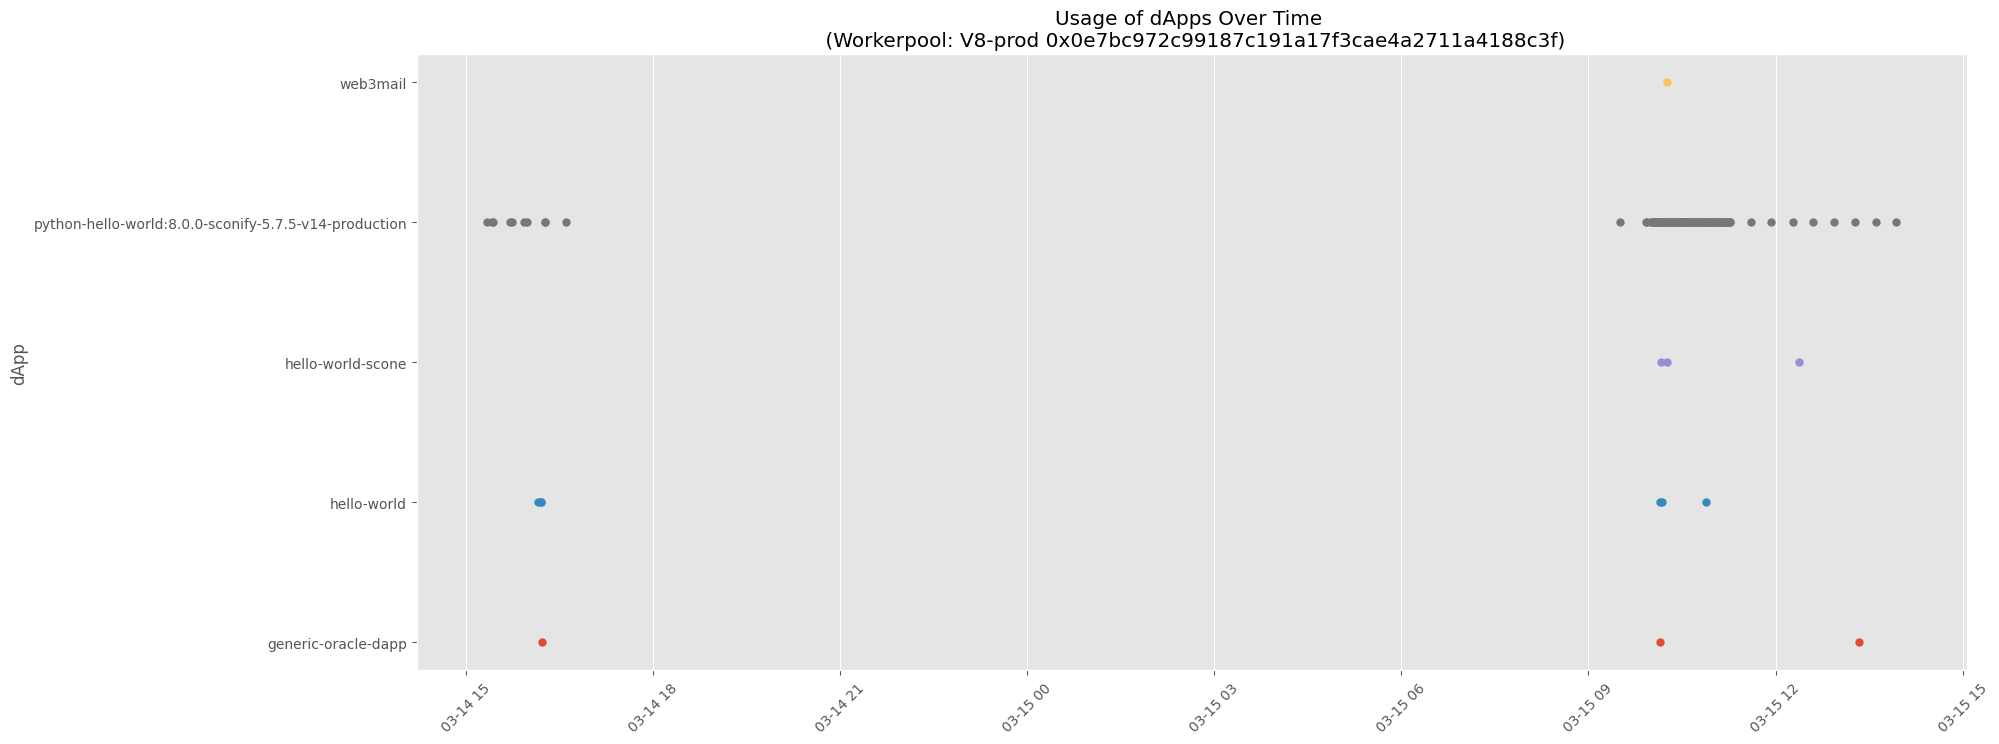

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Assuming df is your DataFrame containing the dApps data
# Filter the DataFrame based on the 'WORKERPOOL ID'
#workerpool_filter = ('0x0e7bc972c99187c191a17f3cae4a2711a4188c3f','0xdb214a4a444d176e22030be1ed89da1b029320f2')
#duration=(1,7,30);


def taskplot(df,workerpool_filter, duration, wp_name):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)
    date_filtered_df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
    filtered_df = date_filtered_df[date_filtered_df['WORKERPOOL ID'] == workerpool_filter]

    # Group by app name and date to count the number of uses of each dApp on each date
    app_usage = filtered_df.groupby(['APP NAME', pd.Grouper(key='DATE', freq='D')]).size().unstack(fill_value=0)

    # Get unique app names for y-axis ticks
    dapp_names = app_usage.index

    # Calculate figsize based on the number of dApps
    fig_height = max(1, len(dapp_names) * 0.5)  # Minimum height of 6 inches
    plt.figure(figsize=(25, fig_height))

    # Plot usage events for each dApp
    for i, app in enumerate(dapp_names):
        usage_dates = filtered_df[filtered_df['APP NAME'] == app]['DATE']
        plt.plot(usage_dates, [i] * len(usage_dates), marker='o', linestyle='', markersize=5, label=app)

    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    plt.title('Usage of dApps Over Time \n Workerpool: {} \n {} \n Last {} day(s)  [{} -> {}]'.format(wp_name,workerpool_filter, str(duration), start_date_str, end_date_str))

    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.ylabel('dApp')
    plt.yticks(range(len(dapp_names)), dapp_names)  # Set y-axis ticks to be the unique app names
    # Extend y-axis plot
    plt.ylim(-0.5, len(dapp_names) - 0.5)

  #plt.legend()  # Add legend to show dApp names

    plt.grid(axis='y')
    plt.show()


taskplot(df_tasks_30d, '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f', 1, "V8_prod")
taskplot(df_tasks_30d, '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f', 7, "V8_prod")
taskplot(df_tasks_30d, '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f', 30, "V8_prod")
taskplot(df_tasks_30d, '0xdb214a4a444d176e22030be1ed89da1b029320f2', 1, "V8_debug")
taskplot(df_tasks_30d, '0xdb214a4a444d176e22030be1ed89da1b029320f2', 7, "V8_debug")
taskplot(df_tasks_30d, '0xdb214a4a444d176e22030be1ed89da1b029320f2', 30, "V8_debug")


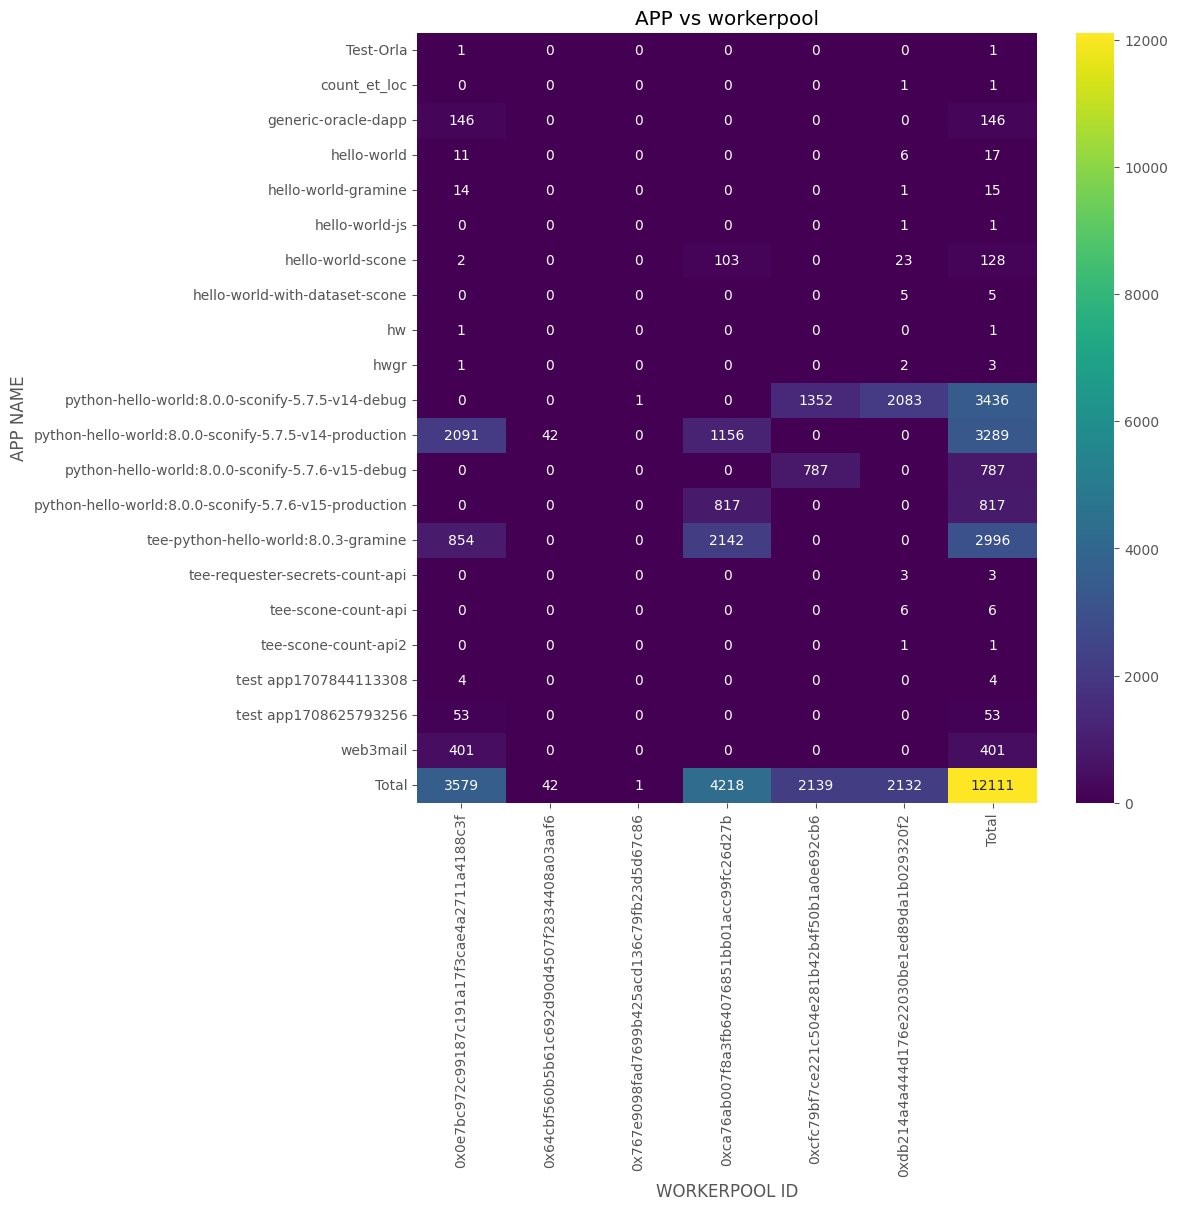

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Assuming df is your DataFrame containing the data grouped by app name and worker pool ID
crosstab = pd.crosstab(df_tasks_30d['APP NAME'], df_tasks_30d['WORKERPOOL ID'], margins=True, margins_name='Total')

# Remove the 'Total' column and row
crosstab = crosstab.drop('Total', axis=0)
crosstab = crosstab.drop('Total', axis=1)

# Calculate the total usage of each app across all worker pools
app_total_usage = crosstab.sum(axis=1)

# Sort the apps based on total usage
sorted_apps = app_total_usage.sort_values(ascending=False).index

# Reindex the crosstab DataFrame based on the sorted apps
crosstab_sorted = crosstab.reindex(index=sorted_apps)

# Create a heatmap using Seaborn
plt.figure(figsize=(22, 22))
heatmap = sns.heatmap(crosstab_sorted, annot=True, fmt='d', cmap='viridis')

plt.title('APP vs workerpool')

# Set xlabel on top
plt.xlabel('WORKERPOOL ID', fontsize=14, labelpad=20, ha='center')

heatmap.xaxis.tick_top()
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, ha='left')

plt.show()


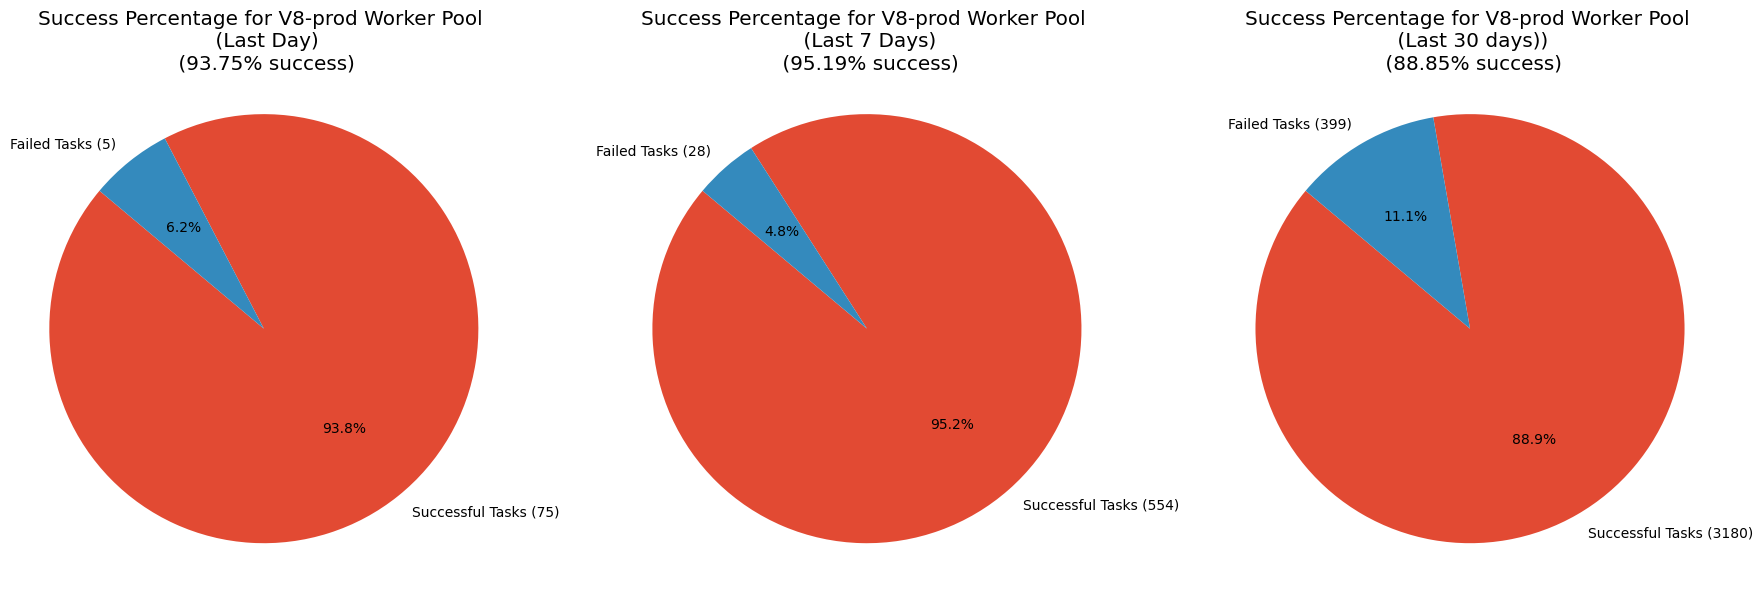

In [ ]:
# @title Success Rate per WorkerPool

import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, timedelta

# Function to calculate the percentage of successful tasks
def calculate_success_percentage(total_tasks, successful_tasks):
    if total_tasks == 0:
        return 0
    return (successful_tasks / total_tasks) * 100

# Function to plot a pie chart with percentage and value
def plot_pie_chart(ax, successful_tasks, total_tasks, title):
    success_percentage = calculate_success_percentage(total_tasks, successful_tasks)
    failed_tasks = total_tasks - successful_tasks

    ax.pie([successful_tasks, failed_tasks], labels=[f'Successful Tasks ({successful_tasks})', f'Failed Tasks ({failed_tasks})'], autopct='%1.1f%%', startangle=140,colors=['lightgreen', 'lightcoral'])
    ax.set_title(title + f' ({success_percentage:.2f}% success)', fontsize=12, fontweight='bold')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    ax.legend(loc='upper right', fontsize=10)

# Define the date interval
date_begin = df_tasks_30d['DATE'].min().strftime("%Y-%m-%d")
date_end = df_tasks_30d['DATE'].max().strftime("%Y-%m-%d")

# Assuming 'df_tasks_30d' is your DataFrame with task data



def successrate(dftmp, duration):
  # Calculate the date range for each time interval
  # Replace 'specific_workerpool_id' with the actual ID of the worker pool you're interested in
  workerpool_prod = '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f'
  workerpool_debug = '0xdb214a4a444d176e22030be1ed89da1b029320f2'
  end_date = datetime.now()
  start_date = end_date - timedelta(days=duration)

  # Filter the DataFrame for each time interval
  df_datefiltered = dftmp[(dftmp['DATE'] >= start_date) & (dftmp['DATE'] <= end_date)]

  # Filter the DataFrame further for the specific worker pool
  df_prod = df_datefiltered[df_datefiltered['WORKERPOOL ID'] == workerpool_prod]
  df_debug = df_datefiltered[df_datefiltered['WORKERPOOL ID'] == workerpool_debug]


  # Calculate the total number of tasks and successful tasks for each time interval
  total_tasks_prod = len(df_prod)
  successful_tasks_prod = len(df_prod[df_prod['STATUS'] == 'COMPLETED'])
  total_tasks_debug = len(df_debug)
  successful_tasks_debug = len(df_debug[df_debug['STATUS'] == 'COMPLETED'])

  # Create a figure with subplots
  fig, axs = plt.subplots(1, 2, figsize=(12, 4))
  # Plot pie charts for each time interval

  start_date_str = start_date.strftime("%Y-%m-%d")
  end_date_str = end_date.strftime("%Y-%m-%d")
  titleprod=('Success Rate on V8-prod Worker Pool \n Workerpool: \n {} \n Last {} day(s) \n [{} -> {}]'.format(workerpool_prod, str(duration), start_date_str, end_date_str))
  titledebug=('Success Rate on V8-debug Worker Pool \n Workerpool: \n {} \n Last {} day(s) \n [{} -> {}]'.format(workerpool_debug, str(duration), start_date_str, end_date_str))
  
  plot_pie_chart(axs[0], successful_tasks_prod, total_tasks_prod, titleprod)
  plot_pie_chart(axs[1], successful_tasks_debug, total_tasks_debug, titledebug)
  # Adjust layout and show plot
  plt.tight_layout()
  plt.show()

successrate(df_tasks_30d, 1)
successrate(df_tasks_30d, 7)
successrate(df_tasks_30d, 30)



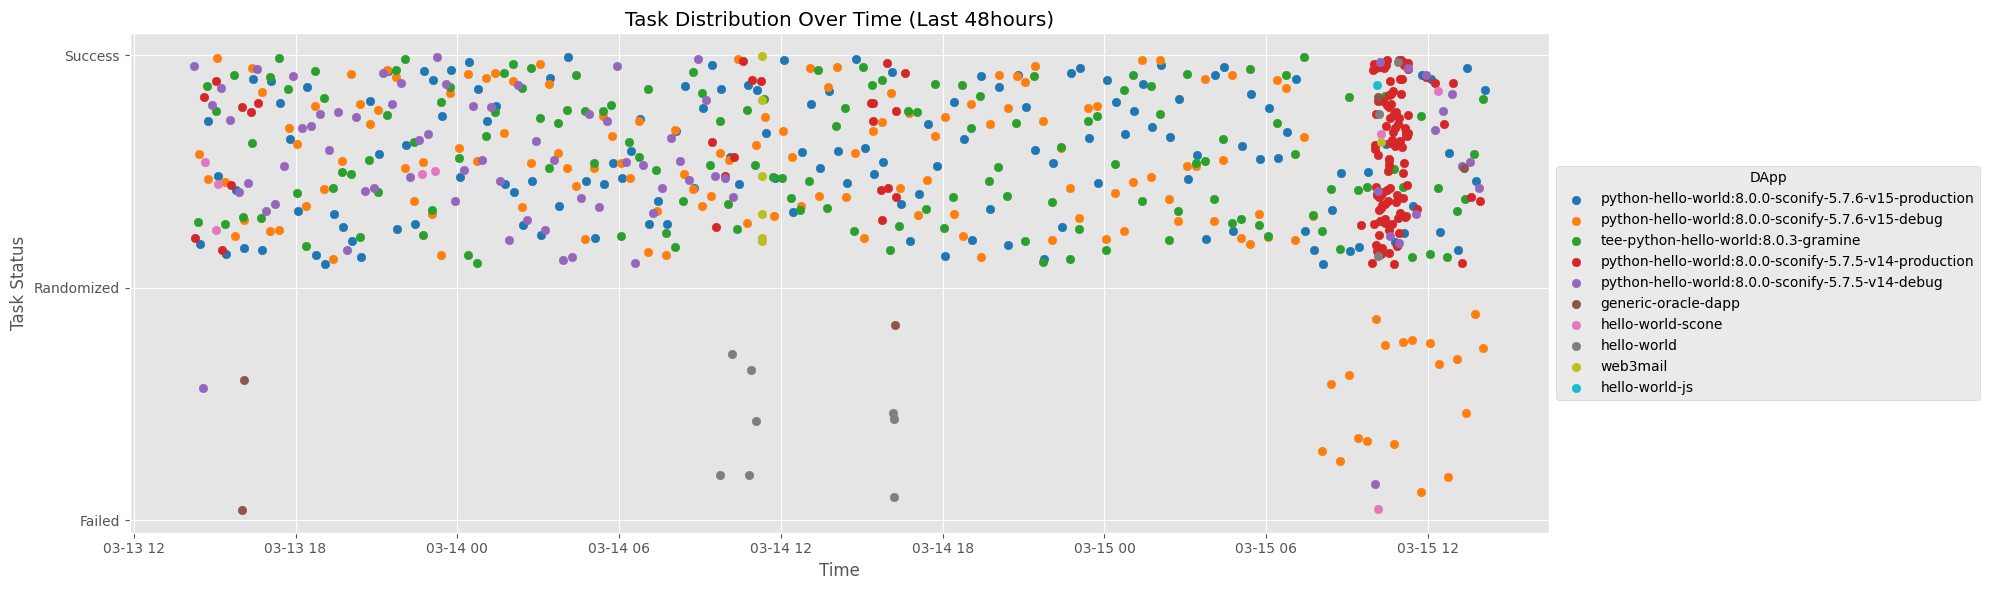

In [ ]:
# @title Show Time Distribution Successful and failed apps in the last days

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import random

workerpool_prod = '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f'
workerpool_debug = '0xdb214a4a444d176e22030be1ed89da1b029320f2'

def success_repartition(df_tmp, workerpool, duration, wp_name):

    # Filter the DataFrame for the last day
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)
    df_datefiltered = df_tmp[(df_tmp['DATE'] >= start_date) & (df_tmp['DATE'] <= end_date)]
    # Filter the DataFrame further for the specific worker pool
    df_wpfiltered = df_datefiltered[df_datefiltered['WORKERPOOL ID'] == workerpool]

    # Create a dictionary to map DApp names to colors and marker types
    dapp_info = {}
    for i, dapp in enumerate(df_wpfiltered['APP NAME'].unique()):
        dapp_info[dapp] = {
            'color': plt.cm.tab20(i/len(df_wpfiltered['APP NAME'].unique())),
            'marker': 'o'  # Use the same marker type for each DApp
        }

    # Plot successful and unsuccessful points using the same marker type per DApp
    plt.figure(figsize=(20, 6))
    for dapp, info in dapp_info.items():
        dapp_df = df_wpfiltered[df_wpfiltered['APP NAME'] == dapp]
        success_mask = dapp_df['STATUS'] == 'COMPLETED'

        # Generate random y-coordinates for successful points in the range [0.1, 1]
        random_success_y = np.random.uniform(low=0.1, high=1, size=np.sum(success_mask))
        # Generate random y-coordinates for unsuccessful points in the range [-1, -0.1]
        random_failure_y = np.random.uniform(low=-1, high=-0.1, size=np.sum(~success_mask))

        # Plot successful points
        plt.scatter(dapp_df['DATE'][success_mask], random_success_y, color=info['color'], label=f'{dapp}', marker=info['marker'])
        # Plot unsuccessful points
        plt.scatter(dapp_df['DATE'][~success_mask], random_failure_y, color=info['color'], marker=info['marker'])

    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    title=('Tasks Success/fail distribution on \n {}  \n Workerpool: \n {} \n Last {} day(s) \n [{} -> {}]'.format(wp_name, workerpool, str(duration), start_date_str, end_date_str))
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Task Status')
    plt.yticks([-1, 0, 1], ['Failed', '', 'Success'])

    # Create a single legend for both success and failure
    plt.legend(title='DApp', loc='center left', bbox_to_anchor=(1, 0.5))

    plt.grid(True)
    plt.tight_layout()

    plt.show()

success_repartition(df_tasks_30d,workerpool_prod,1, "V8_prod")
success_repartition(df_tasks_30d,workerpool_prod,7, "V8_prod")
success_repartition(df_tasks_30d,workerpool_prod,30, "V8_prod")

success_repartition(df_tasks_30d,workerpool_debug,1, "V8_debug")
success_repartition(df_tasks_30d,workerpool_debug,7, "V8_debug")
success_repartition(df_tasks_30d,workerpool_debug,30, "V8_debug")



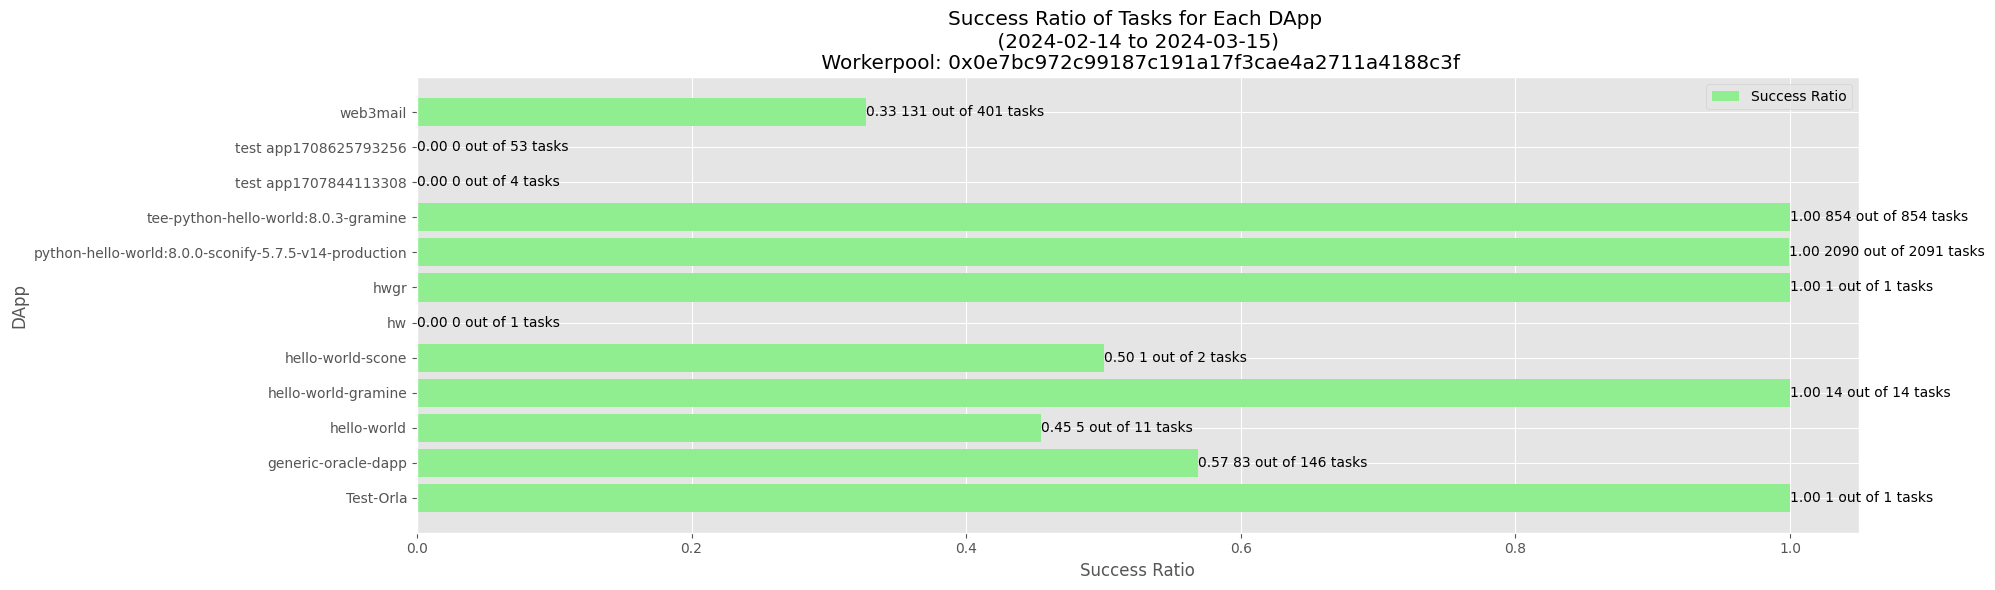

In [ ]:
import matplotlib.pyplot as plt

# Define the workerpool
workerpool_prod = '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f'
workerpool_debug = '0xdb214a4a444d176e22030be1ed89da1b029320f2'

def successrate_app(df_tmp, workerpool):
    # Filter the DataFrame to include only tasks associated with the specified workerpool
    workerpool_df = df_tmp[df_tmp['WORKERPOOL ID'] == workerpool]

    # Define the date interval
    date_begin = df_tmp['DATE'].min().strftime("%Y-%m-%d")
    date_end = df_tmp['DATE'].max().strftime("%Y-%m-%d")

    # Calculate the success ratio for each DApp within the specified workerpool
    dapp_data = {}
    for dapp, group in workerpool_df.groupby('APP NAME'):
        total_count = group.shape[0]
        success_count = group[group['STATUS'] == 'COMPLETED'].shape[0]
        ratio = success_count / total_count if total_count != 0 else 0
        dapp_data[dapp] = {'ratio': ratio, 'success_count': success_count, 'total_count': total_count}

    # Sort the dapp_data dictionary by the total_count of tasks
    sorted_dapp_data = dict(sorted(dapp_data.items(), key=lambda item: item[1]['total_count'], reverse=False))

    # Create a bar plot
    fig_height = max(1, len(sorted_dapp_data) * 0.3)  # Calculate figsize based on the number of dApps
    plt.figure(figsize=(25, fig_height))

    plt.barh(list(sorted_dapp_data.keys()), [d['ratio'] for d in sorted_dapp_data.values()], color='lightgreen', label='Success Ratio')
    plt.xlabel('Success Ratio')
    plt.ylabel('DApp')
    plt.title(f'Success Ratio of Tasks for Each DApp \n ({date_begin} to {date_end}) \n Workerpool: {workerpool}')
    plt.legend()

    # Add annotations for success ratio and total task count
    for i, (dapp, data) in enumerate(sorted_dapp_data.items()):
        plt.text(data['ratio'], i, f'{data["ratio"]:.2f} {data["success_count"]} out of {data["total_count"]} tasks', verticalalignment='center')

    plt.tight_layout()
    plt.show()

successrate_app(df_tasks_30d, workerpool_prod)
successrate_app(df_tasks_30d, workerpool_debug)


In [ ]:
# @title Extract tasks in failure on the last 24 hours

from datetime import datetime, timedelta

# Define the date range for the last days
end_date = datetime.now()
start_date = end_date - timedelta(days=1)  # Adjust the number of days as needed

# Filter the DataFrame for the specified date range and workerpool ID
filtered_df = df_tasks_30d[(df_tasks_30d['DATE'] >= start_date) & (df_tasks_30d['DATE'] <= end_date) & (df_tasks_30d['WORKERPOOL ID'] == '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f') & (df_tasks_30d['STATUS'] != 'COMPLETED')]

# Exclude successful tasks
filtered_df = filtered_df[filtered_df['STATUS'] != 'success']

# Group by 'APP NAME' and aggregate Task IDs as a list
unsuccessful_dapps_per_name = filtered_df.groupby('APP NAME')['TASK_ID'].agg(list)

# Display the result
for app_name, task_ids in unsuccessful_dapps_per_name.items():
    print(f"Unsuccessful DApp: {app_name}")
    for task_id in task_ids:
        print(f"Task ID: {task_id}")
    print()

Unsuccessful DApp: generic-oracle-dapp
Task ID: 0xab3f5a8876cb7116e71bf31386305b33f37fd0a10b181ba7d537b00103836a0f

Unsuccessful DApp: hello-world
Task ID: 0xe6fbbef73ec304e542cc69d40a8c5cad81642bc45d7ce8c391a4fe6c393657b7
Task ID: 0x88b0fe3d020fdc4c7272d201da638e4fe2cf8a0070e4bc8f2e17943c38b6baa1
Task ID: 0x88beb53928e0fba9568f79a2d22632ce69262ba8d51ef410f6e0947a96947f40

Unsuccessful DApp: hello-world-scone
Task ID: 0x684f8708e94f63b09ece122dae89ff0ebd8d5e0a72931a0d4d80d82fa8549eb9



<ipython-input-54-9d5f59d9ccc7>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_apps.index, y=top_apps.values, palette='viridis')


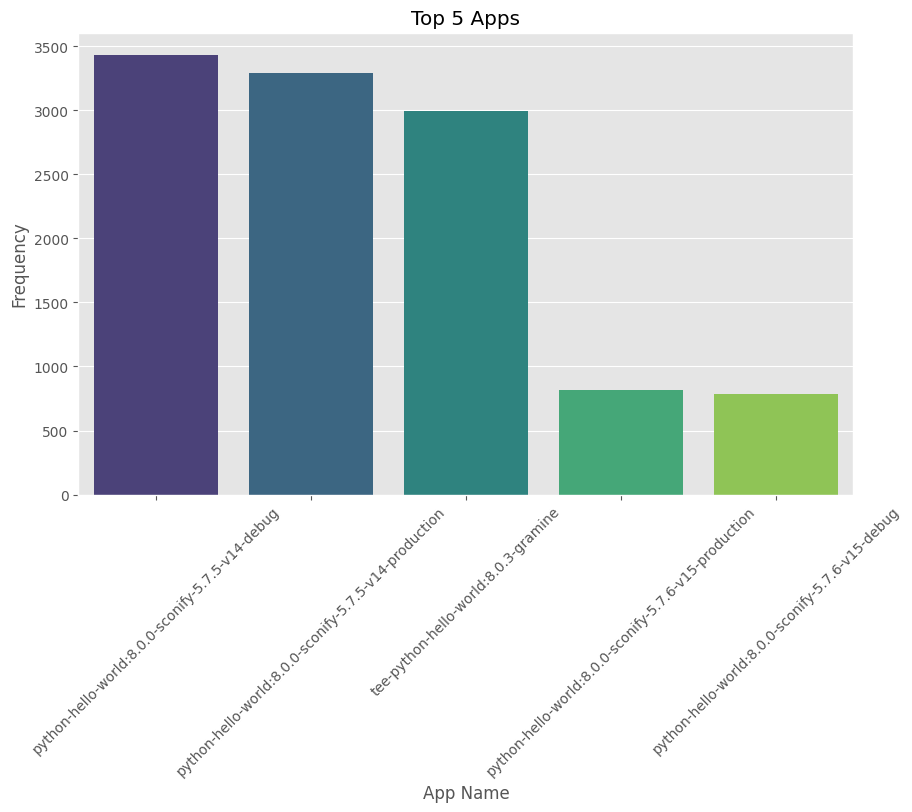

<ipython-input-54-9d5f59d9ccc7>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_workerpools.index, y=top_workerpools.values, palette='magma')


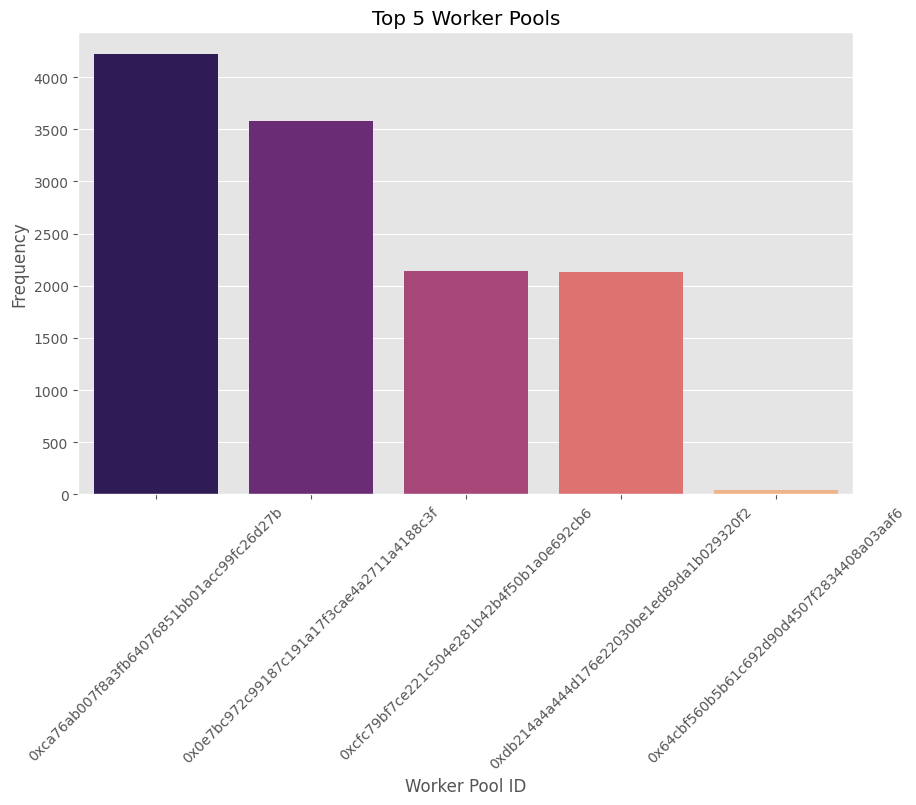

<ipython-input-54-9d5f59d9ccc7>:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_requesters.index, y=top_requesters.values, palette='plasma')


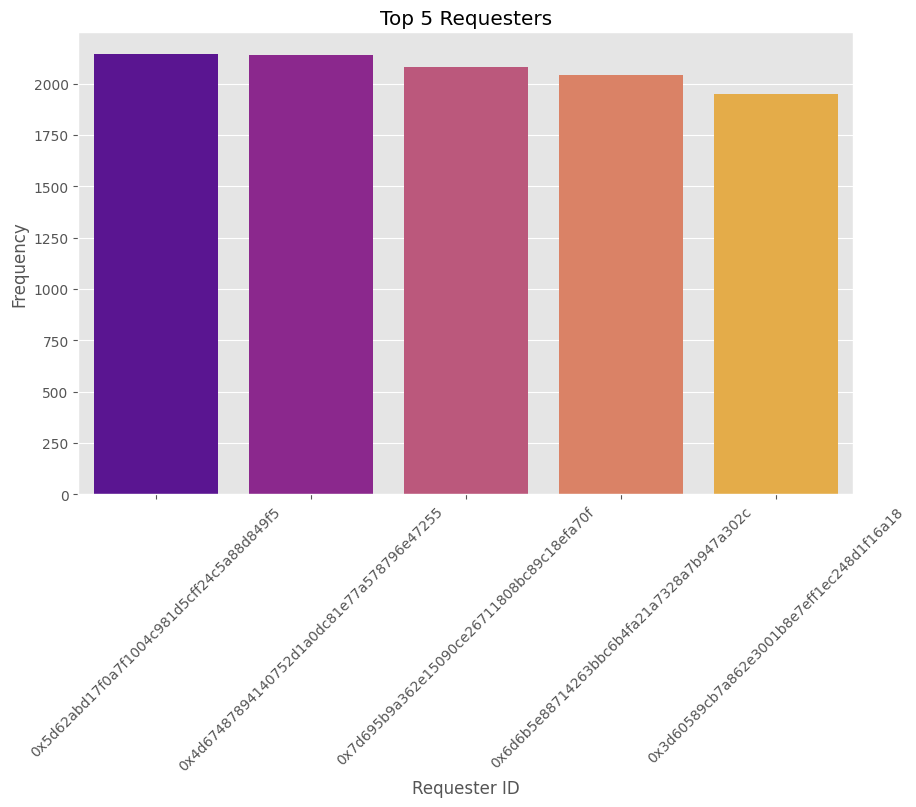

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming your dataset is stored in a DataFrame named df

# Top 5 Apps
top_apps = df['APP NAME'].value_counts().nlargest(100)
plt.figure(figsize=(12, 12))
sns.barplot(x=top_apps.index, y=top_apps.values, palette='viridis')
plt.title('Top 5 Apps')
plt.xlabel('App Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Top 5 Worker Pools
top_workerpools = df['WORKERPOOL ID'].value_counts().nlargest(100)
plt.figure(figsize=(12,12))
sns.barplot(x=top_workerpools.index, y=top_workerpools.values, palette='magma')
plt.title('Top 5 Worker Pools')
plt.xlabel('Worker Pool ID')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Top 5 Requesters
top_requesters = df['REQUESTER ID'].value_counts().nlargest(5)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_requesters.index, y=top_requesters.values, palette='plasma')
plt.title('Top 5 Requesters')
plt.xlabel('Requester ID')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


## Section 4 : Save historical data in google drive

Pre requisite : Google Drive connected
Save data in google Drive, Control filename to avoid overwrite existing dataset

In [ ]:
# @title Save data in csv file on google drive [USE CAREFULLY!!!!!!]
#Define the period

#Method 1 with test
date_begin = '2024-02-01 00:00:00'
date_end = '2024-03-01 00:00:00'
filename='/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/data/Dataset_2024_02.csv'
date_begin = datetime.strptime(date_begin, '%Y-%m-%d %H:%M:%S')
date_end = datetime.strptime(date_end, '%Y-%m-%d %H:%M:%S')

print ("Period to retrieve:", date_begin, date_end)

api_data = get_api_data_iexec_interval(url_query_bellecour, query, 0, date_begin, date_end)
df = pd.DataFrame(api_data, columns=["TASK_ID","APP NAME", "APP MULTIADDR", "TAG", "STATUS", "DATE", "WORKERPOOL ID", "REQUESTER ID"])
df["DATE"] = [datetime.utcfromtimestamp(int(x)) for x in df["DATE"]]

print("Period observed", df["DATE"].min(), df["DATE"].max())
print("dataset length: " + str(df.shape[0]))

#print(filename)
#date_str = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
#new_filename = f"{filename}.csv"

# Save the DataFrame to CSV with the new filename
#df.to_csv(filename, index=False)


Period to retrieve: 2024-02-01 00:00:00 2024-03-01 00:00:00
i= 500 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 1000 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 1500 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 2000 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 2500 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 3000 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 3500 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 4000 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 4500 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 5000 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 5500 are_data: False_are_data: False grouped size 0 array_data size: 500
i= 6000 are_data: True_are_data: True grouped size 426 array_data size: 500
i= 6500 are_data: True_are_da

## Section 5 : Load full historical data from google drive


In [ ]:
# @title Load dataset from csv file store on google drive

import os
import pandas as pd

# Directory containing CSV files
directory='/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/data/'

# List to store DataFrames from each CSV file
dfs = []

# Iterate over each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Read CSV file into a DataFrame
        filepath = os.path.join(directory, filename)
        dftmp = pd.read_csv(filepath)
        dftmp['DATE'] = pd.to_datetime(dftmp['DATE'])
        _begin = dftmp['DATE'].min().strftime("%Y-%m-%d")
        _end = dftmp['DATE'].max().strftime("%Y-%m-%d")
        print(str(filename) + " " + str(_begin) + " " + str(_end))
        # Append DataFrame to the list
        dfs.append(dftmp)

# Concatenate all DataFrames into a single DataFrame
concatenated_df = pd.concat(dfs, ignore_index=True)


_begin = concatenated_df['DATE'].min().strftime("%Y-%m-%d")
_end = concatenated_df['DATE'].max().strftime("%Y-%m-%d")
print("global dataframe: " + str(concatenated_df.shape) +" " + str(_begin) + " " + str(_end))


Dataset_2024_01.csv 2024-01-01 2024-01-31
Dataset_2023_12.csv 2023-12-01 2023-12-31
Dataset_2023_11.csv 2023-11-01 2023-11-30
Dataset_2023_10.csv 2023-10-01 2023-10-31
Dataset_2023_09.csv 2023-09-01 2023-09-30
Dataset_2023_08.csv 2023-08-01 2023-08-31
Dataset_2023_07.csv 2023-07-01 2023-07-31
Dataset_2023_06.csv 2023-06-01 2023-06-30
Dataset_2023_05.csv 2023-05-01 2023-05-31
Dataset_2023_04.csv 2023-04-01 2023-04-30
Dataset_2023_03.csv 2023-03-01 2023-03-31
Dataset_2023_02.csv 2023-02-01 2023-02-28
Dataset_2023_01.csv 2023-01-01 2023-01-31
Dataset_2022_S2.csv 2022-07-01 2022-12-31
Dataset_2022_S1.csv 2022-01-01 2022-06-30
Dataset_2021.csv 2021-01-01 2021-12-31
Dataset_2020.csv 2020-07-15 2020-12-31
Dataset_2024_02.csv 2024-02-01 2024-02-29
global dataframe: (677445, 8) 2020-07-15 2024-02-29


In [ ]:
concatenated_df

,TASK_ID,APP NAME,APP MULTIADDR,TAG,STATUS,DATE,WORKERPOOL ID,REQUESTER ID
0,0xfa4afe75ff9fb2c68cb0fc40e686e0d42c7bb1955eef...,python-hello-world:8.0.0-sconify-5.7.5-v14-pro...,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-01-31 23:57:35,0x0e7bc972c99187c191a17f3cae4a2711a4188c3f,0x6d6b5e88714263bbc6b4fa21a7328a7b947a302c
1,0x403050f30a97c01965687c5e90d86543b82a29b217e7...,python-hello-world:8.0.0-sconify-5.7.5-v14-debug,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-01-31 23:55:25,0xdb214a4a444d176e22030be1ed89da1b029320f2,0x7d695b9a362e15090ce26711808bc89c18efa70f
2,0x6feffc7cb97853cc0e4fd25c3e3fc4cf596e3bed0566...,tee-python-hello-world:8.0.3-gramine,docker.io/iexechub/tee-python-hello-world:8.0....,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-01-31 23:53:55,0x0e7bc972c99187c191a17f3cae4a2711a4188c3f,0x8d6f890ea5d10134cd6b9777457eb75e76312304
3,0x80e6c4810f9420aea0b82e24780e3c283a4215639253...,python-hello-world:7.0.5-sconify-5.3.15-v12-pr...,docker.io/iexechub/python-hello-world:7.0.5-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-01-31 23:53:25,0xeb14dc854a8873e419183c81a657d025ec70276b,0x1d6ce6c05043c28672218b103acb1e017babb68e
4,0xbdefde575ef5c7c9f470fb66b9e685ae961bfc18fd64...,python-hello-world:8.0.0-sconify-5.7.5-v14-pro...,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-01-31 23:37:25,0x0e7bc972c99187c191a17f3cae4a2711a4188c3f,0x6d6b5e88714263bbc6b4fa21a7328a7b947a302c
...,...,...,...,...,...,...,...,...
677440,0x4489abc89f1582bbde6b701637fbb90d702408c1733c...,python-hello-world:8.0.0-sconify-5.7.5-v14-pro...,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-02-01 00:17:40,0x0e7bc972c99187c191a17f3cae4a2711a4188c3f,0x6d6b5e88714263bbc6b4fa21a7328a7b947a302c
677441,0xf8646337e698b850dd9a901f6c593a4d53fcbb5a92d6...,python-hello-world:8.0.0-sconify-5.7.5-v14-debug,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-02-01 00:15:35,0xdb214a4a444d176e22030be1ed89da1b029320f2,0x7d695b9a362e15090ce26711808bc89c18efa70f
677442,0xc1af2f8dc4dd2e4c46dda8d6f6d3e46a19398f480fd4...,tee-python-hello-world:8.0.3-gramine,docker.io/iexechub/tee-python-hello-world:8.0....,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-02-01 00:14:05,0x0e7bc972c99187c191a17f3cae4a2711a4188c3f,0x8d6f890ea5d10134cd6b9777457eb75e76312304
677443,0x300aa7505e364130eabd88dc77f1bc80b6e518801cfe...,python-hello-world:7.0.5-sconify-5.3.15-v12-pr...,docker.io/iexechub/python-hello-world:7.0.5-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-02-01 00:13:05,0xeb14dc854a8873e419183c81a657d025ec70276b,0x1d6ce6c05043c28672218b103acb1e017babb68e


In [ ]:
# @title Display dataset struture and date info

print("Period observed", concatenated_df["DATE"].min(), concatenated_df["DATE"].max())

print("dataset length: " + str(concatenated_df.shape[0]))

concatenated_df.dtypes


Period observed 2020-07-15 15:00:15 2024-02-29 23:56:55
dataset length: 677445


TASK_ID                  object
APP NAME                 object
APP MULTIADDR            object
TAG                      object
STATUS                   object
DATE             datetime64[ns]
WORKERPOOL ID            object
REQUESTER ID             object
dtype: object

## Section 6 : Visualize full historical data

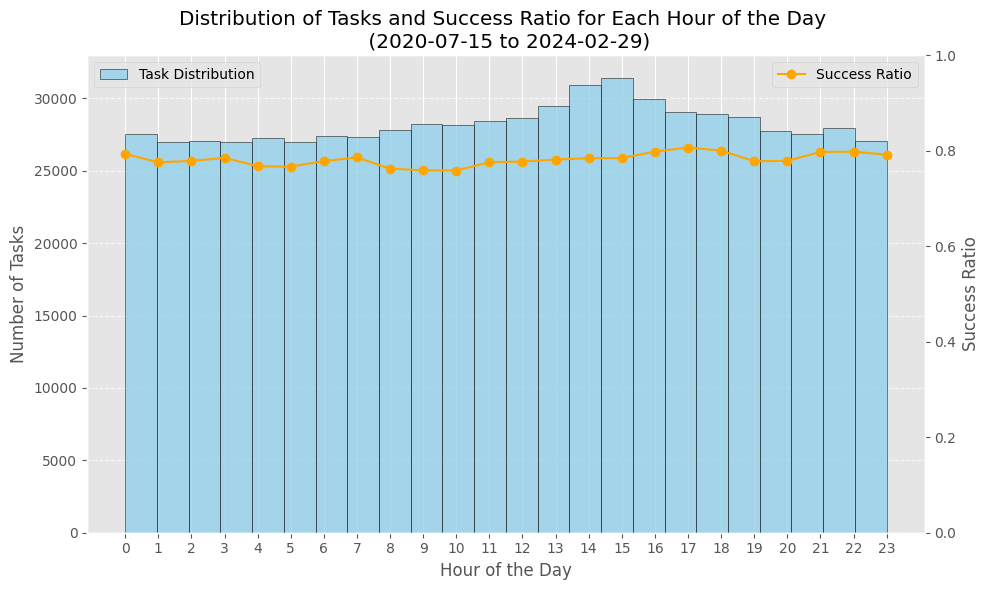

In [ ]:
import matplotlib.pyplot as plt

# Define the date interval
date_begin = concatenated_df['DATE'].min().strftime("%Y-%m-%d")
date_end = concatenated_df['DATE'].max().strftime("%Y-%m-%d")

# Extract the hour component from the 'DATE' column
concatenated_df['Hour'] = concatenated_df['DATE'].dt.hour

# Calculate the total number of tasks for each hour of the day
task_counts = concatenated_df.groupby('Hour').size()

# Calculate the success ratio for each hour of the day
success_counts = concatenated_df[concatenated_df['STATUS'] == 'COMPLETED'].groupby('Hour').size()
success_ratio = success_counts / task_counts

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the distribution of tasks for each hour of the day
ax1.hist(concatenated_df['Hour'], bins=24, color='skyblue', edgecolor='black', alpha=0.7, label='Task Distribution')
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Number of Tasks')
ax1.set_title(f'Distribution of Tasks and Success Ratio for Each Hour of the Day \n ({date_begin} to {date_end})')
ax1.set_xticks(range(24))
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')

# Create a secondary y-axis for success ratio
ax2 = ax1.twinx()
ax2.plot(range(24), success_ratio, color='orange', marker='o', label='Success Ratio')
ax2.set_ylabel('Success Ratio')
ax2.set_ylim(0, 1)
ax2.grid(False)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


<ipython-input-60-65857fc2b5d7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  workerpool_df['Hour'] = workerpool_df['DATE'].dt.hour


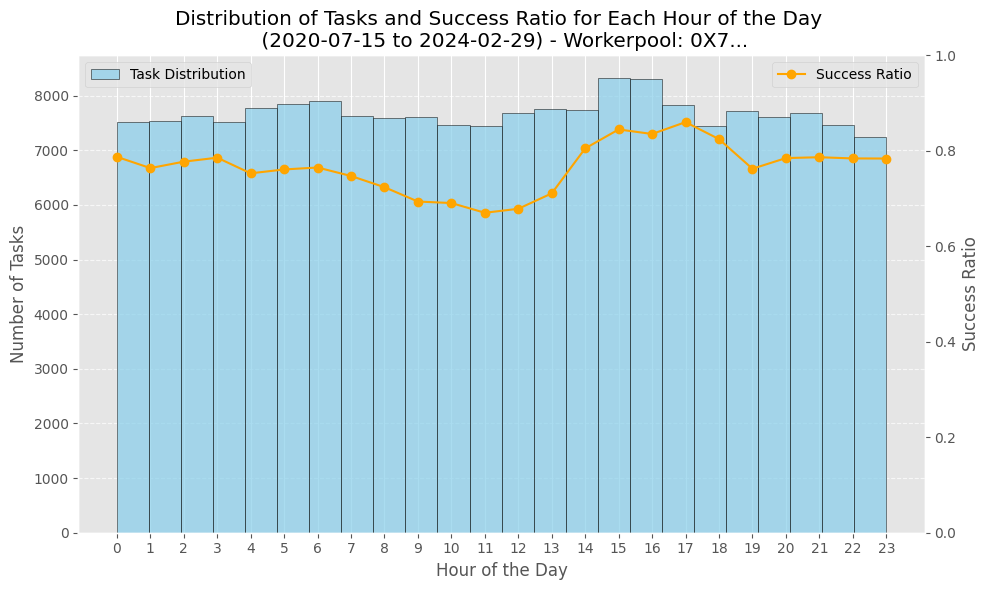

In [ ]:
import matplotlib.pyplot as plt

# Define the date interval
date_begin = concatenated_df['DATE'].min().strftime("%Y-%m-%d")
date_end = concatenated_df['DATE'].max().strftime("%Y-%m-%d")

# Filter the DataFrame to include only tasks associated with the specified workerpool
workerpool_df = concatenated_df[concatenated_df['WORKERPOOL ID'] == '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f']  # Replace '0X7...' with the actual workerpool ID

# Extract the hour component from the 'DATE' column
workerpool_df['Hour'] = workerpool_df['DATE'].dt.hour

# Calculate the total number of tasks for each hour of the day within the specified workerpool
task_counts = workerpool_df.groupby('Hour').size()

# Calculate the success ratio for each hour of the day within the specified workerpool
success_counts = workerpool_df[workerpool_df['STATUS'] == 'COMPLETED'].groupby('Hour').size()
success_ratio = success_counts / task_counts

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the distribution of tasks for each hour of the day within the specified workerpool
ax1.hist(workerpool_df['Hour'], bins=24, color='skyblue', edgecolor='black', alpha=0.7, label='Task Distribution')
ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Number of Tasks')
ax1.set_title(f'Distribution of Tasks and Success Ratio for Each Hour of the Day \n ({date_begin} to {date_end}) - Workerpool: 0X7...')
ax1.set_xticks(range(24))
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')

# Create a secondary y-axis for success ratio
ax2 = ax1.twinx()
ax2.plot(range(24), success_ratio, color='orange', marker='o', label='Success Ratio')
ax2.set_ylabel('Success Ratio')
ax2.set_ylim(0, 1)
ax2.grid(False)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


<ipython-input-61-3b9681752f57>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  workerpool_df['Day of Week'] = workerpool_df['DATE'].dt.dayofweek


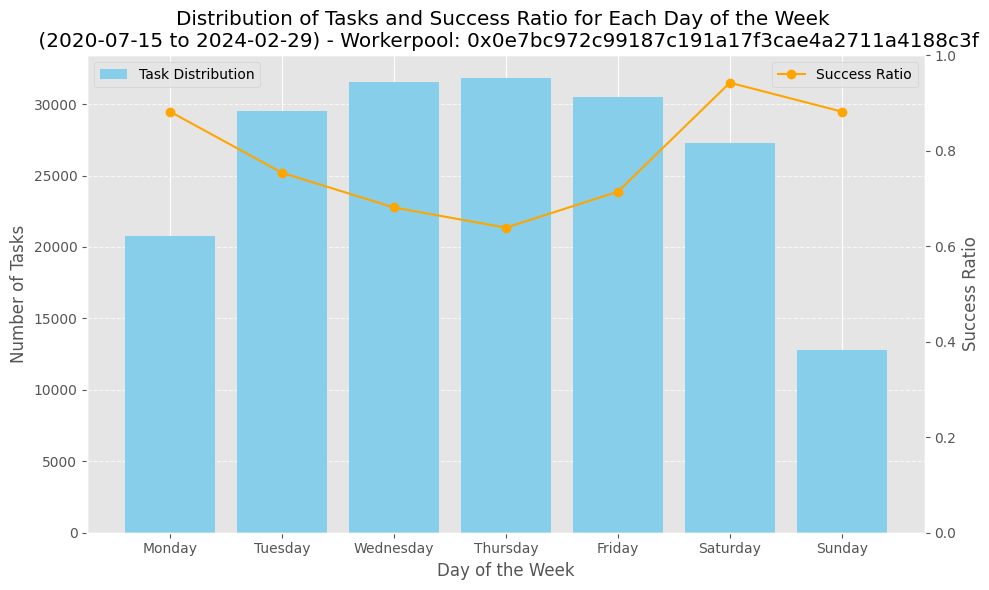

In [ ]:
import matplotlib.pyplot as plt

# Define the date interval
date_begin = concatenated_df['DATE'].min().strftime("%Y-%m-%d")
date_end = concatenated_df['DATE'].max().strftime("%Y-%m-%d")

# Filter the DataFrame to include only tasks associated with the specified workerpool
workerpool_df = concatenated_df[concatenated_df['WORKERPOOL ID'] == '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f']  # Replace '0X7...' with the actual workerpool ID

# Extract the day of the week component from the 'DATE' column
workerpool_df['Day of Week'] = workerpool_df['DATE'].dt.dayofweek

# Calculate the total number of tasks for each day of the week within the specified workerpool
task_counts = workerpool_df.groupby('Day of Week').size()

# Calculate the success ratio for each day of the week within the specified workerpool
success_counts = workerpool_df[workerpool_df['STATUS'] == 'COMPLETED'].groupby('Day of Week').size()
success_ratio = success_counts / task_counts

# Create a figure with two subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the distribution of tasks for each day of the week within the specified workerpool
ax1.bar(range(7), task_counts, color='skyblue', label='Task Distribution')
ax1.set_xlabel('Day of the Week')
ax1.set_ylabel('Number of Tasks')
ax1.set_title(f'Distribution of Tasks and Success Ratio for Each Day of the Week \n ({date_begin} to {date_end}) - Workerpool: 0x0e7bc972c99187c191a17f3cae4a2711a4188c3f')
ax1.set_xticks(range(7))
ax1.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc='upper left')

# Create a secondary y-axis for success ratio
ax2 = ax1.twinx()
ax2.plot(range(7), success_ratio, color='orange', marker='o', label='Success Ratio')
ax2.set_ylabel('Success Ratio')
ax2.set_ylim(0, 1)
ax2.grid(False)
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


<ipython-input-62-1ddbcd21c214>:23: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined_counts = top_15_workerpool.append(pd.Series({'Others': other_count}))


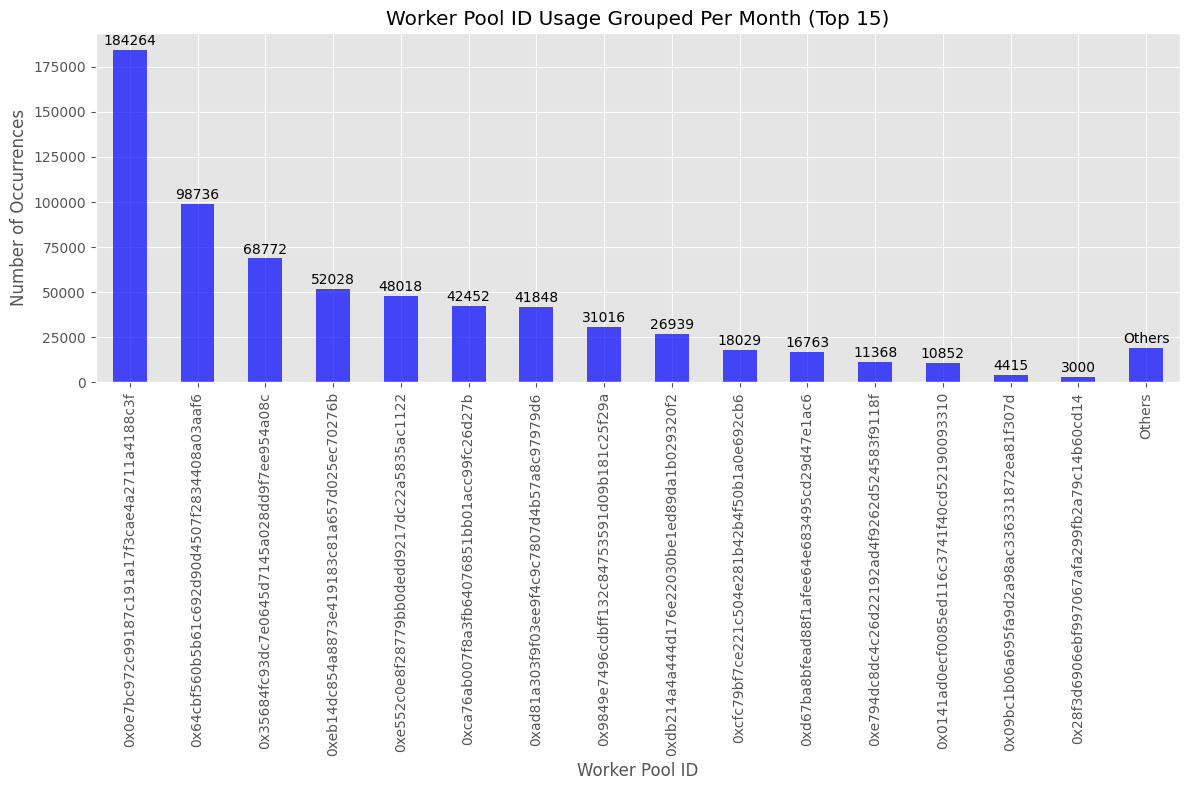

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming concatenated_df is your DataFrame containing the dataset

# Extract month and year from the 'DATE' column
concatenated_df['MONTH'] = concatenated_df['DATE'].dt.month
concatenated_df['YEAR'] = concatenated_df['DATE'].dt.year

# Group by 'WORKERPOOL ID', 'YEAR', and 'MONTH', and count the occurrences
usage_per_month = concatenated_df.groupby(['WORKERPOOL ID', 'YEAR', 'MONTH']).size().reset_index(name='COUNT')

# Aggregate the counts of all worker pool IDs
total_counts = usage_per_month.groupby('WORKERPOOL ID')['COUNT'].sum()

# Select the top 15 worker pool IDs
top_15_workerpool = total_counts.nlargest(15)

# Group the rest into a new label "Others"
other_count = total_counts.drop(top_15_workerpool.index).sum()

# Combine the counts of the top 15 IDs and the rest
combined_counts = top_15_workerpool.append(pd.Series({'Others': other_count}))

# Plot the worker pool ID distribution usage grouped per month
plt.figure(figsize=(12, 8))
combined_counts.plot(kind='bar', color='blue', alpha=0.7)

# Add labels outside the plot
for i, count in enumerate(combined_counts):
    if i < 15:  # Plot only the top 15 worker pool IDs
        plt.text(i, count + 1000, str(count), ha='center', va='bottom')
    elif i == 15:  # Plot "Others" label
        plt.text(i, count + 1000, 'Others', ha='center', va='bottom')

plt.title('Worker Pool ID Usage Grouped Per Month (Top 15)')
plt.xlabel('Worker Pool ID')
plt.ylabel('Number of Occurrences')
#plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


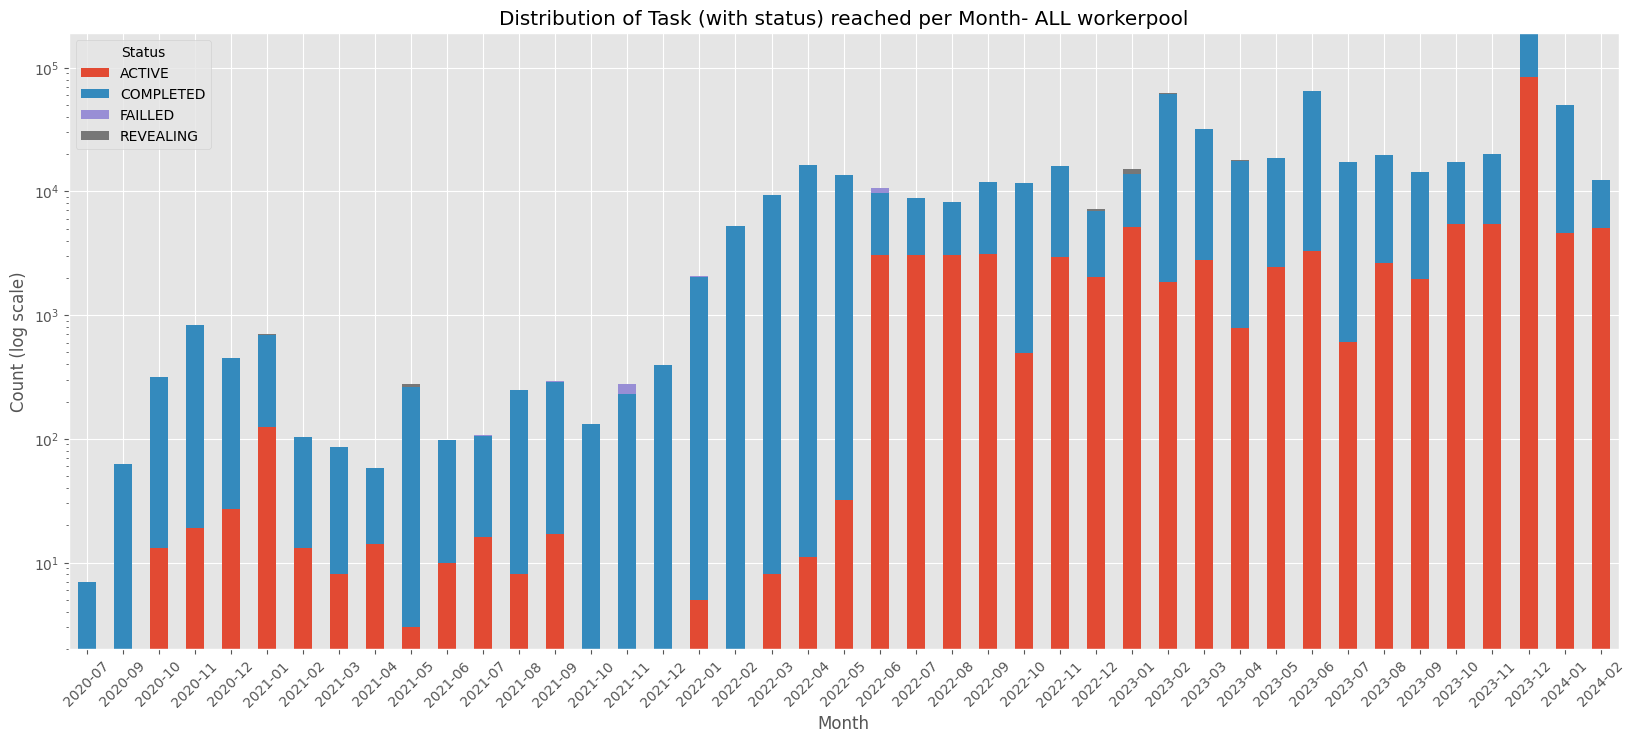

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
# Convert DATE column to datetime if it's not already
concatenated_df['DATE'] = pd.to_datetime(concatenated_df['DATE'])

# Extract month from the DATE column
concatenated_df['Month'] = concatenated_df['DATE'].dt.to_period('M')

# Group by Month and STATUS, count occurrences
status_counts = concatenated_df.groupby(['Month', 'STATUS']).size().unstack(fill_value=0)

# Plot
status_counts.plot(kind='bar', stacked=True, figsize=(20, 8))
plt.title('Distribution of Task (with status) reached per Month- ALL workerpool')
plt.xlabel('Month')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45)
plt.legend(title='Status')

# Change y-axis to log scale
plt.yscale('log')

plt.show()


<ipython-input-64-c9f8eec53e84>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prodhist['DATE'] = pd.to_datetime(df_prodhist['DATE'])
<ipython-input-64-c9f8eec53e84>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prodhist['Month'] = df_prodhist['DATE'].dt.to_period('M')


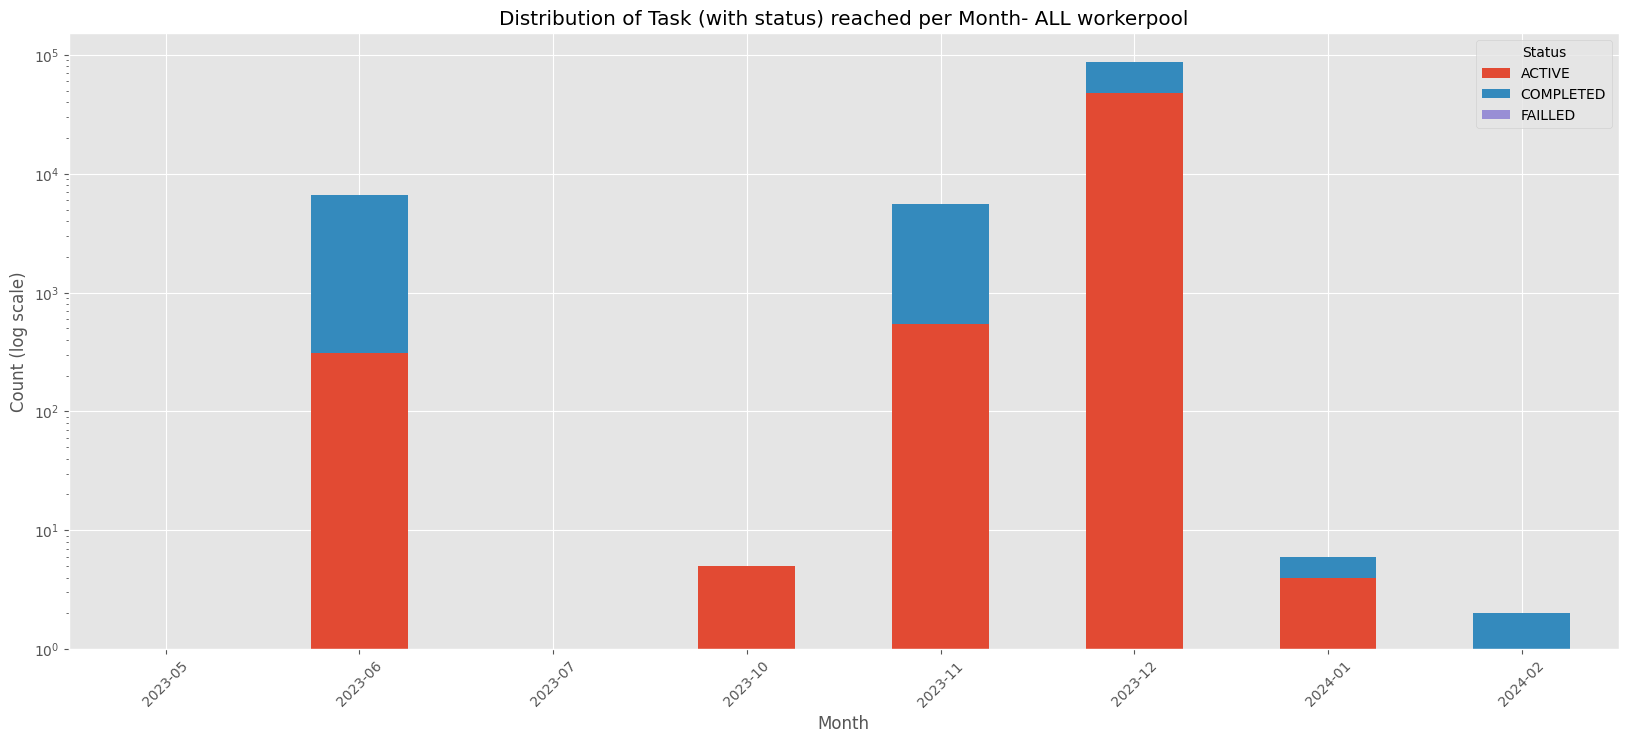

In [ ]:


import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
# Convert DATE column to datetime if it's not already
# Replace 'specific_workerpool_id' with the actual ID of the worker pool you're interested in
#specific_workerpool_id = '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f'  #prod
specific_workerpool_id= '0x64cbf560b5b61c692d90d4507f2834408a03aaf6'  #staging

# Filter the DataFrame further for the specific worker pool
df_prodhist = concatenated_df[concatenated_df['WORKERPOOL ID'] == specific_workerpool_id]

df_prodhist['DATE'] = pd.to_datetime(df_prodhist['DATE'])

# Extract month from the DATE column
df_prodhist['Month'] = df_prodhist['DATE'].dt.to_period('M')

# Group by Month and STATUS, count occurrences
status_counts = df_prodhist.groupby(['Month', 'STATUS']).size().unstack(fill_value=0)

# Plot
status_counts.plot(kind='bar', stacked=True, figsize=(20, 8))
plt.title('Distribution of Task (with status) reached per Month- ALL workerpool')
plt.xlabel('Month')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45)
plt.legend(title='Status')

# Change y-axis to log scale
plt.yscale('log')

plt.show()

PermissionError: [Errno 1] Operation not permitted: '/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/Dashboard_from_collab/Dapp_Success_rate_on_V8-prod-alltime.jpg'

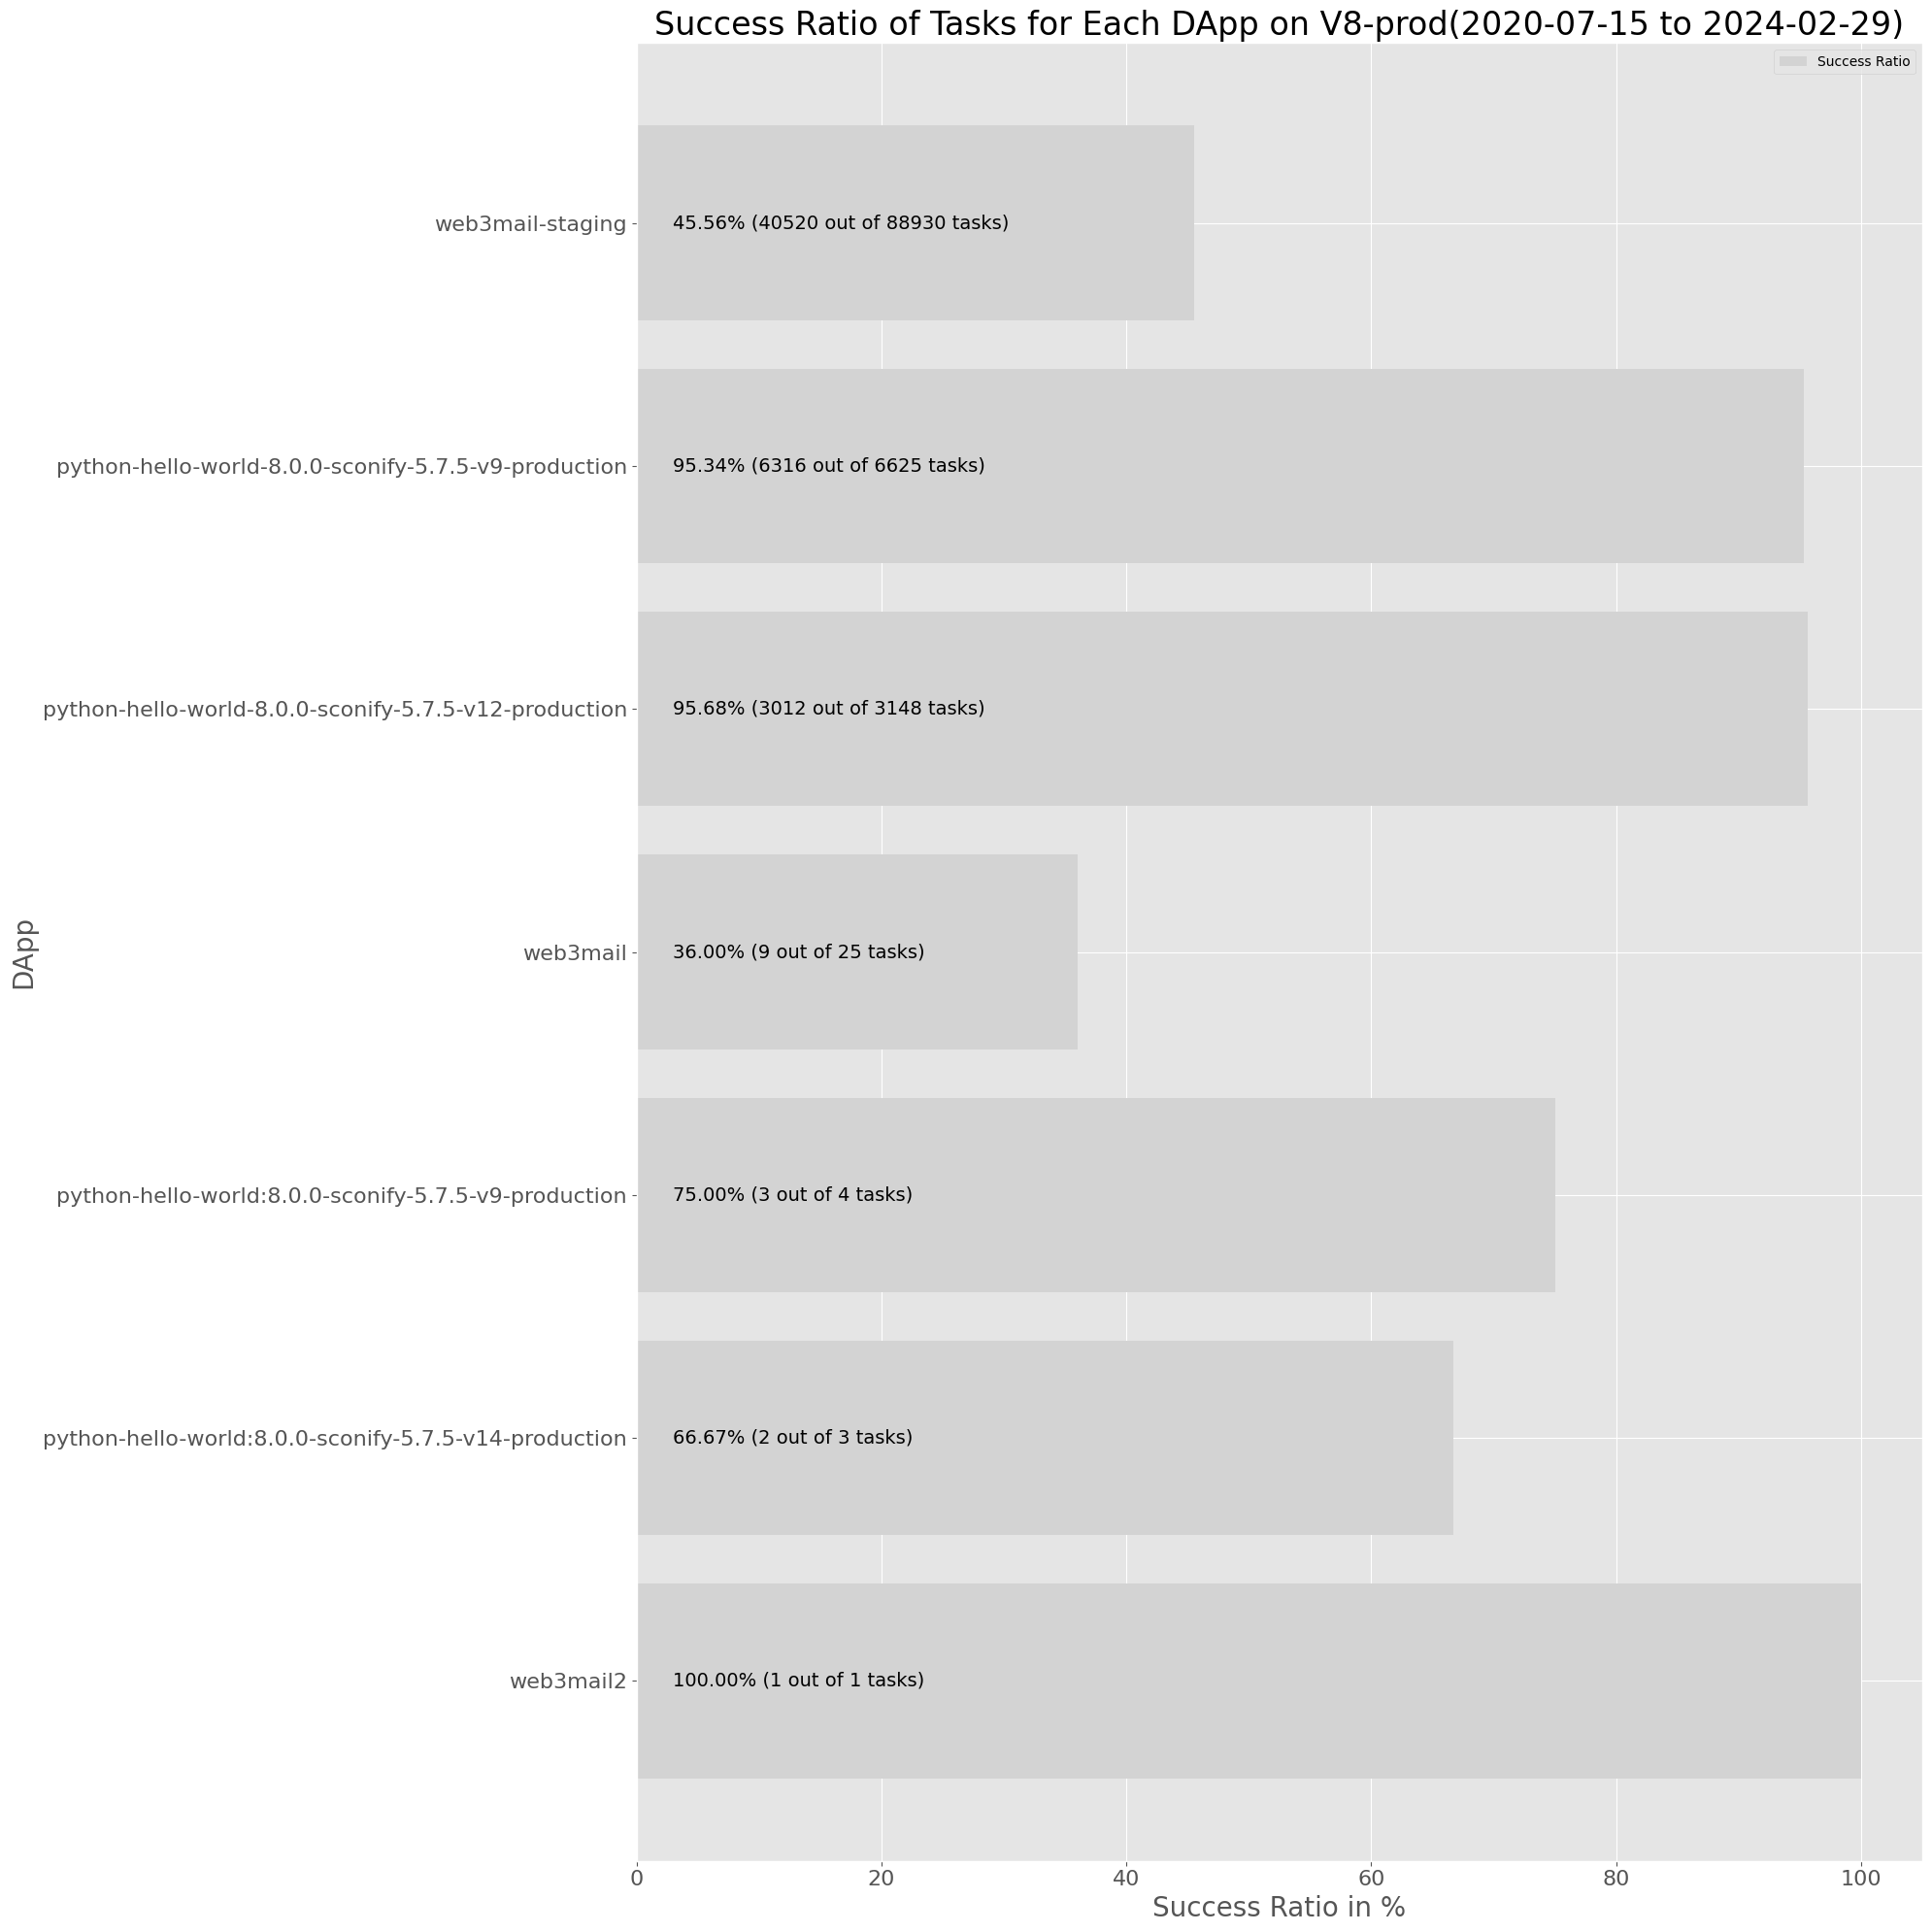

In [ ]:
import matplotlib.pyplot as plt

# Calculate the success ratio for each DApp
dapp_data = {}
for dapp, group in df_prodhist.groupby('APP NAME'):
    total_count = group.shape[0]
    success_count = group[group['STATUS'] == 'COMPLETED'].shape[0]
    ratio = success_count / total_count * 100 if total_count != 0 else 0
    dapp_data[dapp] = {'ratio': ratio, 'success_count': success_count, 'total_count': total_count}

# Sort dapp_data by total_count
sorted_dapp_data = sorted(dapp_data.items(), key=lambda x: x[1]['total_count'], reverse=False)

# Create a bar plot
plt.figure(figsize=(20, 20))
plt.barh([dapp[0] for dapp in sorted_dapp_data], [d[1]['ratio'] for d in sorted_dapp_data], color='lightgrey', label='Success Ratio')
plt.xlabel('Success Ratio in %', fontsize=20)  # Set larger fontsize for xlabel
plt.ylabel('DApp', fontsize=20)  # Set larger fontsize for ylabel
plt.title(f'Success Ratio of Tasks for Each DApp on V8-prod({date_begin} to {date_end})', fontsize=24)  # Set larger fontsize for title
plt.legend()

# Set larger fontsize for tick labels
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add annotations for success ratio and total task count
for i, (dapp, data) in enumerate(sorted_dapp_data):
    plt.text(3 , i, f'{data["ratio"]:.2f}% ({data["success_count"]} out of {data["total_count"]} tasks)', verticalalignment='center', fontsize=14)  # Set larger fontsize for annotations

plt.tight_layout()

# Save the plot before displaying it
output_path = "/content/drive/Shareddrives/App_and_Product/dashboard_marketplace/Dashboard_from_collab"
filename = output_path + "/Dapp_Success_rate_on_V8-prod-alltime.jpg"
plt.savefig(filename)

# Display the plot
plt.show()
